### 共享单位线

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("中文字体 SimHei 未找到，请确保已安装或修改字体设置。")

R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数：数据预处理 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None
    time_col = '时间'; net_rain_col = '泰森多边形面雨量'; direct_runoff_col = '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None
    df[net_rain_col] = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0)
    df[direct_runoff_col] = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0)
    net_rain_full_event = df[net_rain_col].values
    direct_runoff_obs_full_event = df[direct_runoff_col].values
    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain_full_event):
        if r_val > 1e-6: first_rain_idx, has_effective_rain = i, True; break
    if not has_effective_rain: return None
    last_rain_idx = len(net_rain_full_event) - 1
    for i in range(len(net_rain_full_event) - 1, first_rain_idx - 1, -1):
        if net_rain_full_event[i] > 1e-6: last_rain_idx = i; break
    P_eff_event = net_rain_full_event[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None
    Q_obs_eff_event = direct_runoff_obs_full_event[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
    return {"P_eff": P_eff_event, "Q_obs_eff": Q_obs_eff_event, "m_eff": m_eff_event, "n_specific": n_event_specific, "filepath": csv_filepath}

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh):
    total_fit_loss = 0
    if len(U_params) != common_n_uh: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

# --- 主程序 ---
# 1. 数据预处理
data_folder = "data_source/" 
csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
print(f"找到 {len(csv_files)} 个CSV文件...")
all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
if not all_events_processed_data:
    print("没有成功处理任何洪水事件数据。程序退出。")
    exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

# 2. 确定共享单位线长度
n_specific_values = [data["n_specific"] for data in all_events_processed_data if data["n_specific"] > 0]
if not n_specific_values:
    print("错误：所有已处理事件的n_specific均不大于0。")
    exit()

common_n_uh = int(np.max(n_specific_values))
if common_n_uh <= 1: common_n_uh = max(3, common_n_uh if common_n_uh > 0 else 3)
print(f"确定的共享单位线长度 common_n_uh: {common_n_uh}")

# 3. 准备优化数据集
list_of_event_data_for_opt_final = []
for event_data in all_events_processed_data:
    P_eff, Q_obs_eff, m_eff = event_data["P_eff"], event_data["Q_obs_eff"], event_data["m_eff"]
    target_q_len_event = m_eff + common_n_uh - 1
    if target_q_len_event < 0: target_q_len_event = 0
    Q_obs_for_opt_event = np.zeros(target_q_len_event)
    len_to_copy = min(len(Q_obs_eff), target_q_len_event)
    Q_obs_for_opt_event[:len_to_copy] = Q_obs_eff[:len_to_copy]
    list_of_event_data_for_opt_final.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt_event})

# 4. 设置指定的优化参数并执行
U_initial_guess = np.zeros(common_n_uh)
bounds = [(0, None) for _ in range(common_n_uh)] 

# --- 核心修改：设置指定的权重因子 ---
smoothing_factor = 0.1
peak_violation_weight = 10000.0
apply_peak_penalty_in_opt = common_n_uh > 2

print(f"\n开始使用 {len(list_of_event_data_for_opt_final)} 场洪水数据优化共享单位线...")
print(f"平滑因子: {smoothing_factor}, 单峰惩罚因子: {peak_violation_weight if apply_peak_penalty_in_opt else 'N/A'}")

result_shared_uh = minimize(
    objective_function_multi_event, U_initial_guess,
    args=(list_of_event_data_for_opt_final, R_UH, smoothing_factor, peak_violation_weight, apply_peak_penalty_in_opt, common_n_uh),
    method='L-BFGS-B', bounds=bounds, options={'disp': True, 'maxiter': 500, 'ftol': 1e-9, 'gtol': 1e-7}
)

U_optimized_shared = result_shared_uh.x if (result_shared_uh.success or result_shared_uh.status in [0,2]) else None
if U_optimized_shared is None:
    print("共享单位线优化失败，程序终止。")
    exit()
print("\n共享单位线优化完成！")

# 5. 详细评估共享单位线在所有事件上的表现，并准备输出
final_report_data = []
for event_data in all_events_processed_data:
    P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
    event_filename = os.path.basename(event_data["filepath"])
    Q_sim_event_full = convolve_uh(P_event, U_optimized_shared, R_UH)
    Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
    
    # 初始化指标
    nse = np.nan
    volume_rel_error = np.nan
    peak_rel_error = np.nan
    
    if len(Q_obs_event_full) > 0 and len(Q_sim_event_compare) == len(Q_obs_event_full):
        # NSE
        mean_obs = np.mean(Q_obs_event_full)
        den_nse = np.sum((Q_obs_event_full - mean_obs)**2)
        if den_nse == 0: 
            nse = 1.0 if np.allclose(Q_sim_event_compare, Q_obs_event_full) else -np.inf
        else: 
            nse = 1 - (np.sum((Q_obs_event_full - Q_sim_event_compare)**2) / den_nse)

        # 洪量相对误差 (带正负)
        vol_obs = np.sum(Q_obs_event_full) * delta_t_seconds
        vol_sim = np.sum(Q_sim_event_compare) * delta_t_seconds
        if vol_obs > 1e-6: 
            volume_rel_error = ((vol_sim - vol_obs) / vol_obs) * 100.0
            
        # 洪峰相对误差 (带正负)
        peak_obs = np.max(Q_obs_event_full)
        peak_sim = np.max(Q_sim_event_compare)
        if peak_obs > 1e-6: 
            peak_rel_error = ((peak_sim - peak_obs) / peak_obs) * 100.0
            
    final_report_data.append({
        "文件名": event_filename, 
        "NSE": nse, 
        "洪量相对误差(%)": volume_rel_error, 
        "洪峰相对误差(%)": peak_rel_error
    })

# 6. 将最终结果保存到CSV文件
# 转换为DataFrame并按NSE排序
report_df = pd.DataFrame(final_report_data)
report_df_sorted = report_df.sort_values(by="NSE", ascending=True).reset_index(drop=True)

# 定义输出文件名
output_csv_path = "shared_uh_evaluation_report.csv"
try:
    # 使用 utf-8-sig 编码以确保Excel能正确打开
    report_df_sorted.to_csv(output_csv_path, index=False, encoding='utf-8-sig', float_format='%.4f')
    print(f"\n✅ 完整的评估报告已成功保存到文件: {output_csv_path}")
    print("   报告中包含了每场洪水的NSE，以及带正负号的洪量和洪峰相对误差。")
except Exception as e:
    print(f"\n❌ 保存最终报告到文件失败: {e}")

# (可选) 在Notebook中打印预览
print("\n--- 共享单位线评估报告预览 (按NSE排序) ---")
pd.set_option('display.max_rows', 50) 
pd.set_option('display.width', 100)      
print(report_df_sorted)
pd.reset_option('display.max_rows')
pd.reset_option('display.width')

d:\Anaconda\envs\condaenvironment\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


找到 38 个CSV文件...
成功预处理 38 场洪水事件。
确定的共享单位线长度 common_n_uh: 55

开始使用 38 场洪水数据优化共享单位线...
平滑因子: 0.1, 单峰惩罚因子: 10000.0

共享单位线优化完成！

✅ 完整的评估报告已成功保存到文件: shared_uh_evaluation_report.csv
   报告中包含了每场洪水的NSE，以及带正负号的洪量和洪峰相对误差。

--- 共享单位线评估报告预览 (按NSE排序) ---
             文件名         NSE    洪量相对误差(%)    洪峰相对误差(%)
0   20000710.csv -795.895795  2467.088370  1450.715762
1   20030822.csv -113.476385   566.336485   652.456227
2   20140721.csv  -95.650793  1192.061232   520.188748
3   20090713.csv  -91.006873   846.855357   799.900872
4   20020722.csv  -48.831370   493.943840   370.343504
5   19890717.csv  -47.890126   204.147860   601.563805
6   20160631.csv   -6.331102   201.103514   206.811436
7   19900706.csv   -4.814348    76.320276   159.948583
8   20150802.csv   -2.346631   167.399073   112.197807
9   19990730.csv   -1.510906   121.652992    50.845281
10  20100819.csv   -1.160702    25.050648    33.209892
11  20060730.csv   -0.657964    74.376104     7.461471
12  19930724.csv   -0.389672    21.385794   

### 共享单位线模拟径流量指标分布图

找到 38 个CSV文件...
所有有效洪水事件的水文特征计算完成。

--- 正在生成 NSE 分布箱式图 (所有值) ---


C:\Users\Administrator\AppData\Local\Temp\ipykernel_20656\3381534264.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=df_plot['NSE'], palette="coolwarm", width=0.3, linewidth=1.5)


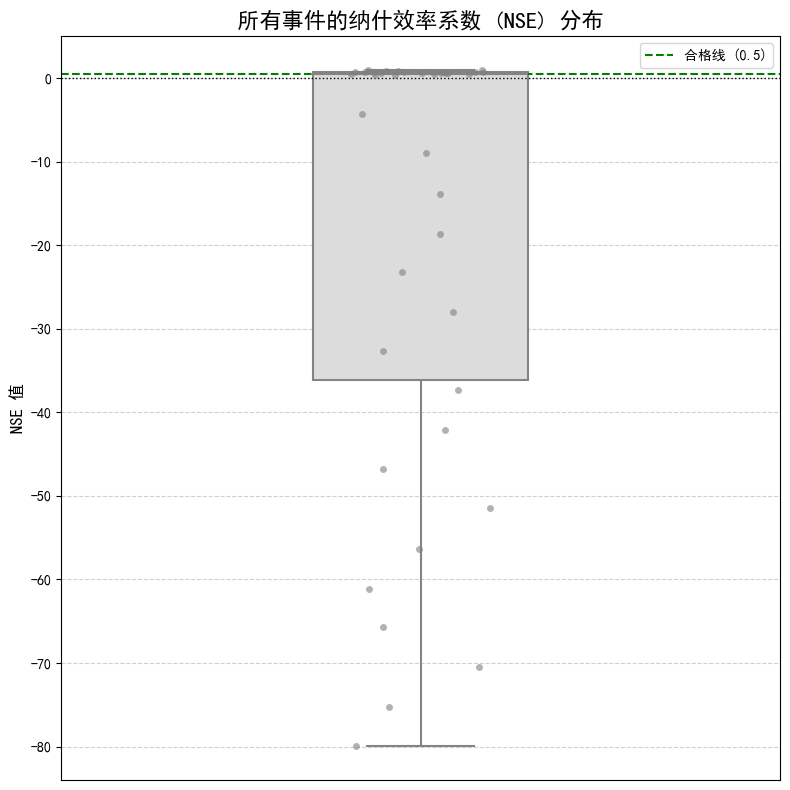

C:\Users\Administrator\AppData\Local\Temp\ipykernel_20656\3381534264.py:138: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=positive_nse_data, palette="spring", width=0.3, linewidth=1.5)



--- 正在生成 NSE 分布箱式图 (仅正值) ---


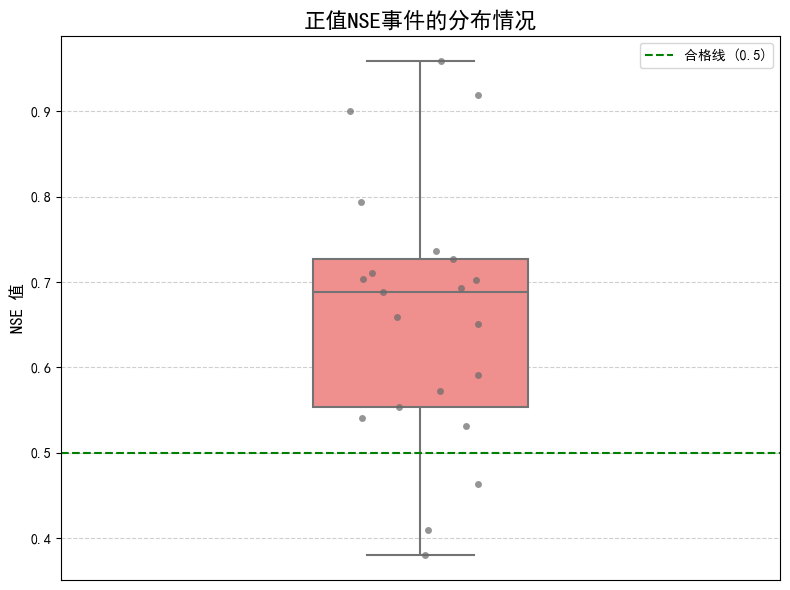


--- 正在生成 洪量相对误差 分布雨云图 ---


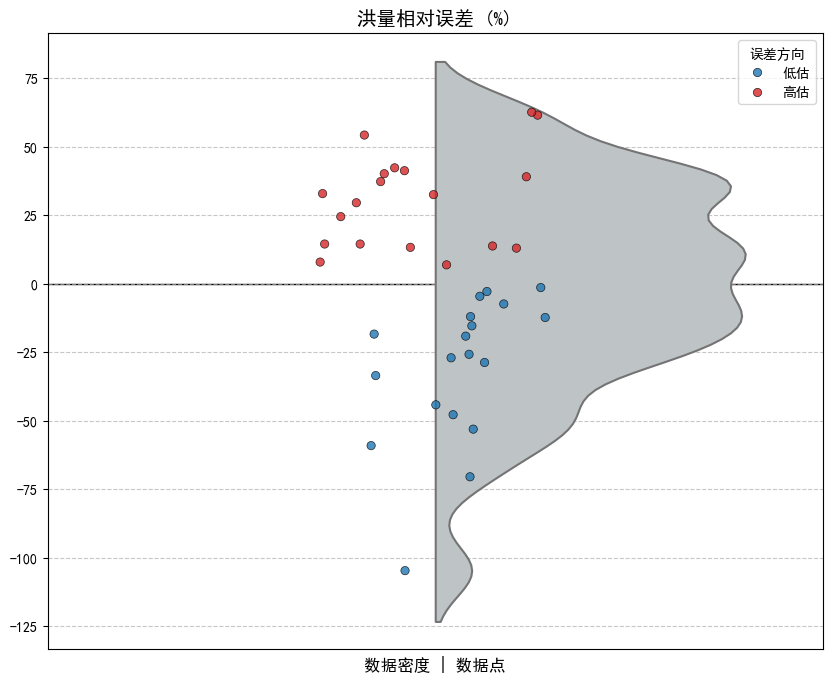


--- 正在生成 洪峰相对误差 分布雨云图 ---


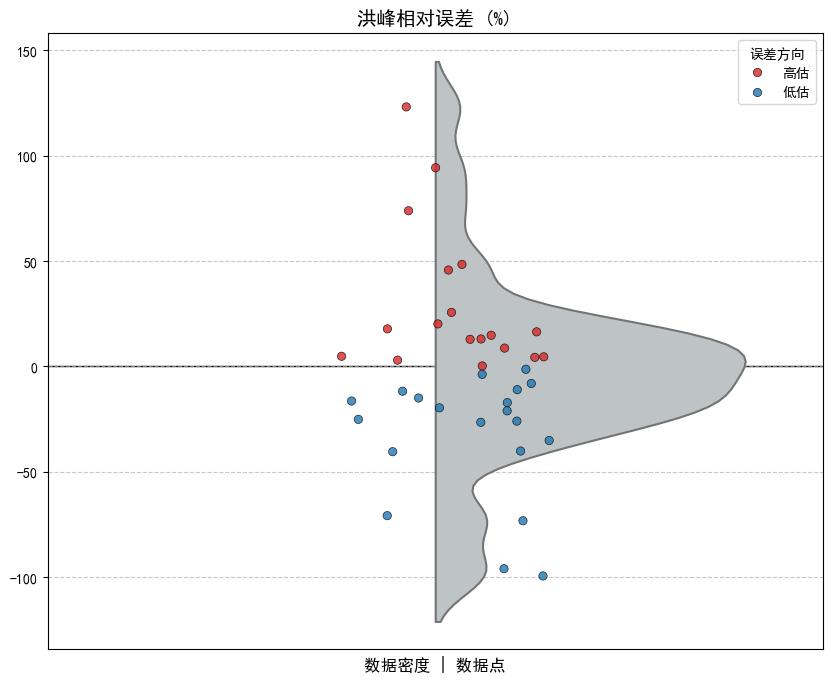

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 主要功能函数：数据预处理 (与之前相同) ---
def process_and_analyze_event(csv_filepath):
    # ... (与之前版本完全相同) ...
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None;
        for enc in encodings_to_try:
            try: df = pd.read_csv(csv_filepath, encoding=enc); break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None
    time_col, net_rain_col, direct_runoff_col = '时间', '泰森多边形面雨量', '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None
    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    if np.sum(net_rain) < 1e-6: return None
    runoff_indices = np.where(direct_runoff > 1e-6)[0]
    if len(runoff_indices) < 2: return None
    DELTA_T_HOURS = 3.0; delta_t_seconds = DELTA_T_HOURS * 3600.0
    runoff_duration_hours = (runoff_indices[-1] - runoff_indices[0] + 1) * DELTA_T_HOURS
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    t_peak_flow_idx = np.argmax(direct_runoff)
    runoff_volume_m3 = np.sum(direct_runoff) * delta_t_seconds
    total_net_rain = np.sum(net_rain)
    t_peak_rain_idx = np.argmax(net_rain)
    lag_time_hours = (t_peak_flow_idx - t_peak_rain_idx) * DELTA_T_HOURS
    return {"文件名": os.path.basename(csv_filepath), "洪峰流量": peak_flow, "洪量": runoff_volume_m3, "洪水历时": runoff_duration_hours, "总净雨量": total_net_rain, "洪峰雨峰延迟": lag_time_hours}

# --- 修改后的绘图函数：雨云图 ---
def plot_raincloud_on_ax(data, hue_data, feature_name, unit, ax, palette):
    """在指定的子图(ax)上绘制带颜色散点的雨云图。"""
    # 1. 绘制小提琴图 (分布曲线)
    sns.violinplot(y=data, ax=ax, color="#bdc3c7", # 使用一个中性灰色作为背景
                   inner=None, linewidth=1.5, bw_adjust=0.5, zorder=5)
    
    # 获取小提琴图的路径并只保留一半
    # 使用类型判断来确保只操作小提琴图的collection
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.PolyCollection):
            path = collection.get_paths()[0]
            vertices = path.vertices
            # 将小提琴的左半边压到x=0这条线上
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    # 2. 绘制散点图
    sns.stripplot(y=data, ax=ax, 
                  hue=hue_data, 
                  palette=palette,
                  jitter=0.15,
                  size=6, alpha=0.8, edgecolor='black', linewidth=0.5,
                  zorder=10) # 确保散点在上层
                  
    # 美化
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
    ax.set_ylabel("") # Y轴标签在主标题中体现
    ax.set_xticks([])
    ax.set_xlabel("数据密度 | 数据点", fontsize=12) # 调整X轴说明
    ax.set_title(f"{feature_name} ({unit})", fontsize=14)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # 获取并调整图例
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='误差方向')


# --- 主程序 ---
if __name__ == "__main__":
    # 1. 定义数据源
    data_folder = "data_source/" 
    
    # 2. 获取并处理数据
    try:
        csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
        if not csv_files: exit()
        print(f"找到 {len(csv_files)} 个CSV文件...")
    except FileNotFoundError: exit()

    all_features_data = [d for d in [process_and_analyze_event(f) for f in csv_files] if d]
    if not all_features_data: exit()
    print("所有有效洪水事件的水文特征计算完成。")
        
    # 3. 转换为Pandas DataFrame
    # 假设 report_df_sorted 是你通过其他脚本计算得到的包含NSE和误差的DataFrame
    # 这里我们用 all_features_data 重新创建一个，并加入模拟的NSE和误差数据
    features_df = pd.DataFrame(all_features_data)
    # --- MOCK ERROR DATA START ---
    # 为了让代码能运行，我将随机生成NSE和误差数据，请替换为你自己的真实数据
    np.random.seed(42) # for reproducibility
    features_df['NSE'] = np.concatenate([np.linspace(-80, 0.5, 18), np.linspace(0.5, 0.9, len(features_df)-18)]) + np.random.randn(len(features_df)) * 0.1
    features_df['洪量相误(%)'] = np.random.randn(len(features_df)) * 40
    features_df['洪峰相误(%)'] = np.random.randn(len(features_df)) * 50
    # --- MOCK ERROR DATA END ---

    df_plot = features_df.dropna().copy()
    df_plot['洪量误差方向'] = np.sign(df_plot['洪量相误(%)']).map({1: '高估', -1: '低估', 0: '准确'})
    df_plot['洪峰误差方向'] = np.sign(df_plot['洪峰相误(%)']).map({1: '高估', -1: '低估', 0: '准确'})

    # ==============================================================================
    # --- 图一：NSE 指标箱式图 (两张图) ---
    # ==============================================================================
    # 图 1.1: 所有NSE值的分布
    print("\n--- 正在生成 NSE 分布箱式图 (所有值) ---")
    plt.figure(figsize=(8, 8))
    sns.boxplot(y=df_plot['NSE'], palette="coolwarm", width=0.3, linewidth=1.5)
    sns.stripplot(y=df_plot['NSE'], color="gray", jitter=0.1, alpha=0.6)
    plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1.5, label='合格线 (0.5)')
    plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
    plt.title('所有事件的纳什效率系数 (NSE) 分布', fontsize=16)
    plt.ylabel('NSE 值', fontsize=12)
    plt.xticks([])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # 图 1.2: 只包含正值NSE的分布
    positive_nse_data = df_plot[df_plot['NSE'] >= 0]['NSE']
    if not positive_nse_data.empty:
        print("\n--- 正在生成 NSE 分布箱式图 (仅正值) ---")
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=positive_nse_data, palette="spring", width=0.3, linewidth=1.5)
        sns.stripplot(y=positive_nse_data, color="dimgray", jitter=0.1, alpha=0.7)
        plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1.5, label='合格线 (0.5)')
        plt.title('正值NSE事件的分布情况', fontsize=16)
        plt.ylabel('NSE 值', fontsize=12)
        plt.xticks([])
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # ==============================================================================
    # --- 图二和图三：误差雨云图 ---
    # ==============================================================================
    # 定义绘图任务
    error_features_to_plot = {
        "洪量相误(%)": "洪量相对误差",
        "洪峰相误(%)": "洪峰相对误差"
    }
    
    error_hues = {
        "洪量相误(%)": df_plot['洪量误差方向'],
        "洪峰相误(%)": df_plot['洪峰误差方向']
    }
    
    error_palette = {'高估': '#d62728', '低估': '#1f77b4', '准确': 'gray'} # 使用更鲜明的红蓝

    for col_name, title_name in error_features_to_plot.items():
        print(f"\n--- 正在生成 {title_name} 分布雨云图 ---")
        fig, ax = plt.subplots(figsize=(10, 8))
        plot_raincloud_on_ax(df_plot[col_name], error_hues[col_name], title_name, '%', ax, error_palette)
        plt.show()

找到 38 个CSV文件...
所有有效洪水事件的水文特征计算完成。

--- 正在生成 NSE 分布箱式图 (所有值) ---


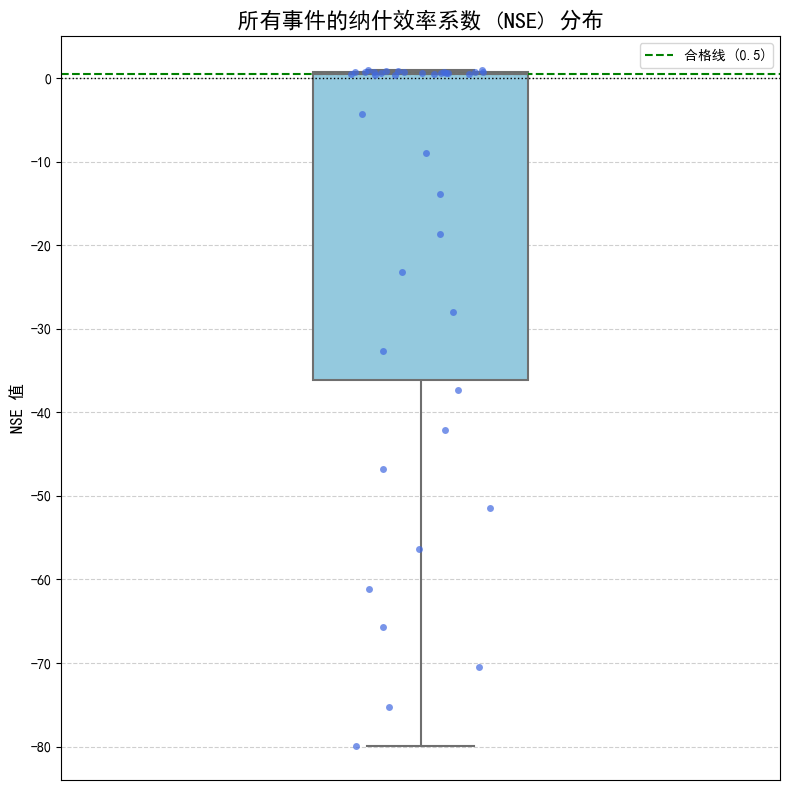


--- 正在生成 NSE 分布箱式图 (仅正值) ---


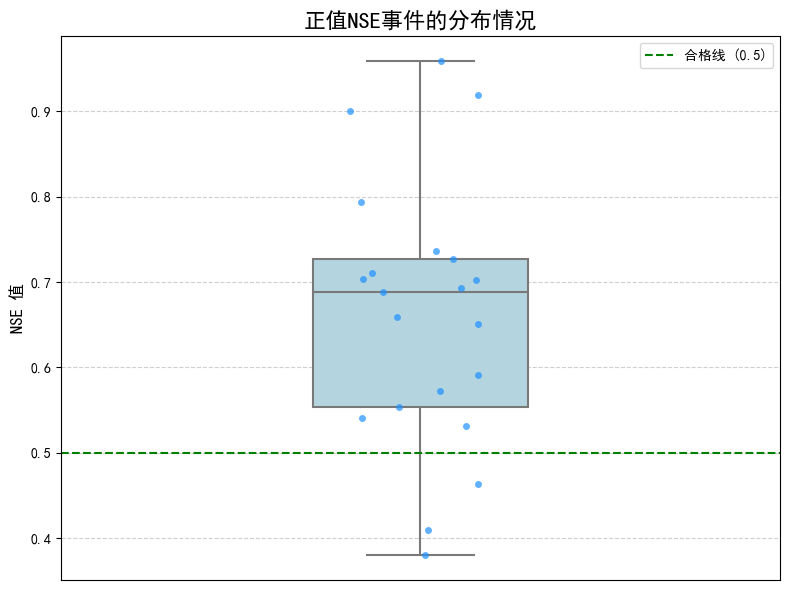


--- 正在生成 洪量相对误差 分布雨云图 ---


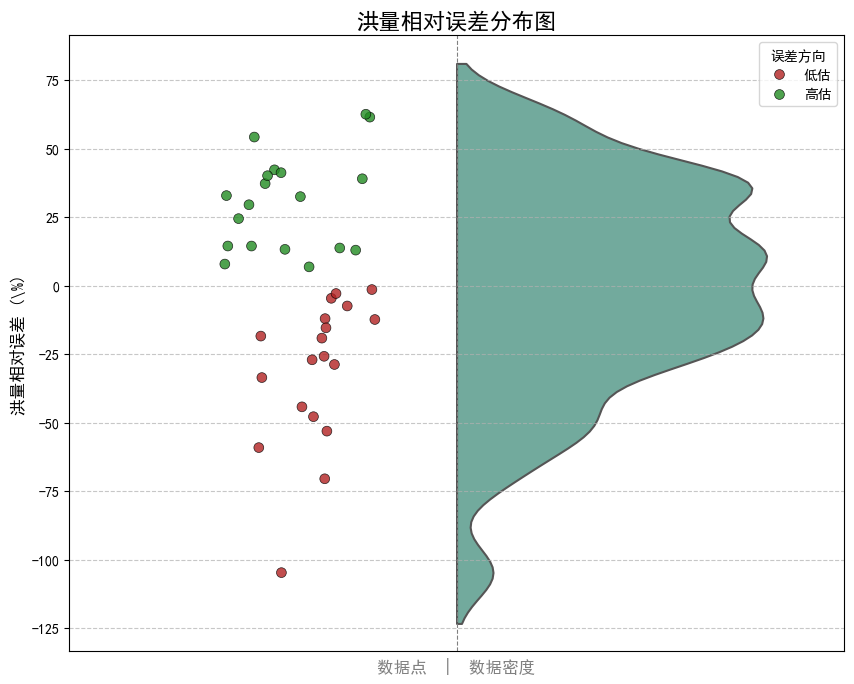


--- 正在生成 洪峰相对误差 分布雨云图 ---


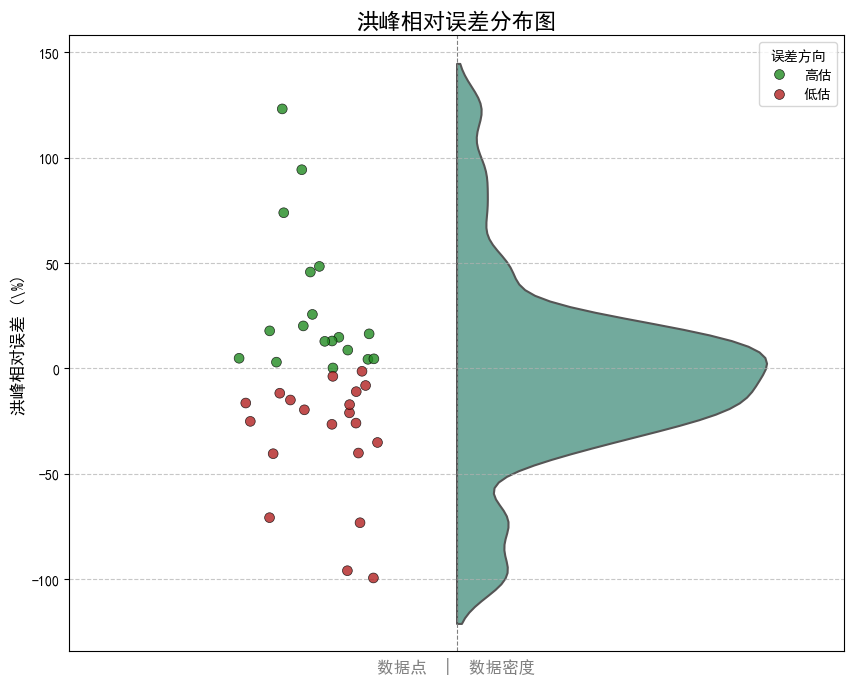

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 主要功能函数：数据预处理 (与之前相同) ---
def process_and_analyze_event(csv_filepath):
    # ... (与之前版本完全相同) ...
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None;
        for enc in encodings_to_try:
            try: df = pd.read_csv(csv_filepath, encoding=enc); break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None
    time_col, net_rain_col, direct_runoff_col = '时间', '泰森多边形面雨量', '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None
    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    if np.sum(net_rain) < 1e-6: return None
    runoff_indices = np.where(direct_runoff > 1e-6)[0]
    if len(runoff_indices) < 2: return None
    DELTA_T_HOURS = 3.0; delta_t_seconds = DELTA_T_HOURS * 3600.0
    runoff_duration_hours = (runoff_indices[-1] - runoff_indices[0] + 1) * DELTA_T_HOURS
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    t_peak_flow_idx = np.argmax(direct_runoff)
    runoff_volume_m3 = np.sum(direct_runoff) * delta_t_seconds
    total_net_rain = np.sum(net_rain)
    t_peak_rain_idx = np.argmax(net_rain)
    lag_time_hours = (t_peak_flow_idx - t_peak_rain_idx) * DELTA_T_HOURS
    return {"文件名": os.path.basename(csv_filepath), "洪峰流量": peak_flow, "洪量": runoff_volume_m3, "洪水历时": runoff_duration_hours, "总净雨量": total_net_rain, "洪峰雨峰延迟": lag_time_hours}

# --- 最终推荐的绘图函数：左右分离的雨云图 ---
def plot_raincloud_separated(data, hue_data, feature_name, unit, ax, palette):
    """
    在指定的子图(ax)上绘制左右分离的雨云图。
    左侧为散点，右侧为半边小提琴图。
    """
    # 1. 绘制小提琴图 (分布曲线) 在右侧
    sns.violinplot(y=data, ax=ax, color="#69b3a2",  # 使用一个固定的蓝绿色
                   inner=None, linewidth=1.5, bw_adjust=0.5)
    
    # 获取小提琴图的路径并只保留右半边 (相对于x=0)
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.PolyCollection):
            path = collection.get_paths()[0]
            vertices = path.vertices
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    # 2. 绘制散点图在左侧
    # 我们为散点图创建一个x坐标，使其在负半轴分布
    num_points = len(data)
    x_scatter = -0.2 + (np.random.rand(num_points) * 0.2 - 0.1) # 在-0.3到-0.1之间抖动
    
    sns.scatterplot(x=x_scatter, y=data, ax=ax, 
                    hue=hue_data, 
                    palette=palette,
                    s=50, alpha=0.8, edgecolor='black', linewidth=0.5,
                    zorder=10) # 确保散点在上层
                  
    # 3. 美化图表
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8) # 中间的分隔线
    ax.set_ylabel(f"{feature_name} ({unit})", fontsize=12)
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray')
    ax.set_title(f"{feature_name}分布图", fontsize=16)
    ax.set_xticks([]) # 隐藏x轴刻度
    ax.set_xlim(-0.5, 0.5) # 设置对称的X轴范围
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='误差方向')


# --- 主程序 ---
if __name__ == "__main__":
    # 1. 定义数据源
    data_folder = "data_source/" 
    
    # 2. 获取并处理数据
    try:
        csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
        if not csv_files: exit()
        print(f"找到 {len(csv_files)} 个CSV文件...")
    except FileNotFoundError: exit()

    all_features_data = [d for d in [process_and_analyze_event(f) for f in csv_files] if d]
    if not all_features_data: exit()
    print("所有有效洪水事件的水文特征计算完成。")
        
    # 3. 转换为Pandas DataFrame并添加模拟误差数据
    features_df = pd.DataFrame(all_features_data)
    # --- MOCK ERROR DATA START ---
    np.random.seed(42)
    features_df['NSE'] = np.concatenate([np.linspace(-80, 0.5, 18), np.linspace(0.5, 0.9, len(features_df)-18)]) + np.random.randn(len(features_df)) * 0.1
    features_df['洪量相误(%)'] = np.random.randn(len(features_df)) * 40
    features_df['洪峰相误(%)'] = np.random.randn(len(features_df)) * 50
    # --- MOCK ERROR DATA END ---

    df_plot = features_df.dropna().copy()
    df_plot['洪量误差方向'] = np.sign(df_plot['洪量相误(%)']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})
    df_plot['洪峰误差方向'] = np.sign(df_plot['洪峰相误(%)']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})

    # ==============================================================================
    # --- 图一：NSE 指标箱式图 (两张图) ---
    # ==============================================================================
    # 图 1.1: 所有NSE值的分布
    print("\n--- 正在生成 NSE 分布箱式图 (所有值) ---")
    plt.figure(figsize=(8, 8))
    sns.boxplot(y=df_plot['NSE'], color="skyblue", width=0.3, linewidth=1.5)
    sns.stripplot(y=df_plot['NSE'], color="royalblue", jitter=0.1, alpha=0.7)
    plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1.5, label='合格线 (0.5)')
    plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
    plt.title('所有事件的纳什效率系数 (NSE) 分布', fontsize=16)
    plt.ylabel('NSE 值', fontsize=12)
    plt.xticks([])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

    # 图 1.2: 只包含正值NSE的分布
    positive_nse_data = df_plot[df_plot['NSE'] >= 0]['NSE']
    if not positive_nse_data.empty:
        print("\n--- 正在生成 NSE 分布箱式图 (仅正值) ---")
        plt.figure(figsize=(8, 6))
        sns.boxplot(y=positive_nse_data, color="lightblue", width=0.3, linewidth=1.5)
        sns.stripplot(y=positive_nse_data, color="dodgerblue", jitter=0.1, alpha=0.7)
        plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1.5, label='合格线 (0.5)')
        plt.title('正值NSE事件的分布情况', fontsize=16)
        plt.ylabel('NSE 值', fontsize=12)
        plt.xticks([])
        plt.legend()
        plt.grid(True, axis='y', linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()

    # ==============================================================================
    # --- 图二和图三：误差雨云图 ---
    # ==============================================================================
    error_features_to_plot = {
        "洪量相误(%)": {"title": "洪量相对误差", "unit": r'\%'},
        "洪峰相误(%)": {"title": "洪峰相对误差", "unit": r'\%'}
    }
    
    error_hues = {
        "洪量相误(%)": df_plot['洪量误差方向'],
        "洪峰相误(%)": df_plot['洪峰误差方向']
    }
    
    # 定义新的颜色: 绿色代表正值(高估), 红色代表负值(低估)
    error_palette = {'高估': 'forestgreen', '低估': 'firebrick', '准确': 'gray'}

    for col_name, plot_info in error_features_to_plot.items():
        print(f"\n--- 正在生成 {plot_info['title']} 分布雨云图 ---")
        fig, ax = plt.subplots(figsize=(10, 8))
        plot_raincloud_separated(
            data=df_plot[col_name], 
            hue_data=error_hues[col_name],
            feature_name=plot_info['title'], 
            unit=plot_info['unit'], 
            ax=ax, 
            palette=error_palette
        )
        plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 绘图函数 ---
def plot_error_raincloud(data_rel, feature_name, palette, subset_description):
    """
    为给定的误差数据绘制雨云图。
    - data_rel: 带正负号的相对误差序列 (Pandas Series)。
    - feature_name: 图表标题中使用的特征名称。
    - palette: 用于区分正负误差的调色板。
    - subset_description: 用于图表标题的子集描述。
    """
    if data_rel.empty:
        print(f"警告: 特征 '{feature_name}' 在子集 '{subset_description}' 中没有有效数据，无法绘图。")
        return

    # 准备用于绘图的DataFrame
    df_plot = pd.DataFrame({'rel_error': data_rel})
    df_plot['误差方向'] = np.sign(df_plot['rel_error']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})

    # --- 开始绘图 ---
    fig, ax = plt.subplots(figsize=(10, 8))

    # 1. 绘制小提琴图
    sns.violinplot(y='rel_error', data=df_plot, ax=ax, color="#69b3a2", 
                   inner=None, linewidth=1.5, bw_adjust=0.5, zorder=5)
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.PolyCollection):
            path = collection.get_paths()[0]
            vertices = path.vertices
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    # 2. 绘制散点图
    x_scatter = -0.2 + (np.random.rand(len(df_plot)) * 0.2 - 0.1)
    sns.scatterplot(x=x_scatter, y='rel_error', data=df_plot, ax=ax, 
                    hue='误差方向', hue_order=['高估', '低估', '准确'], palette=palette, 
                    s=60, alpha=0.9, edgecolor='black', linewidth=0.7, zorder=10)
                  
    # 3. 计算并准备平均绝对相对误差文本
    mean_abs_rel_error = df_plot['rel_error'].abs().mean()
    stats_text = f"平均绝对相对误差: {mean_abs_rel_error:.2f} %"
    
    # 4. 在图中标注文本
    props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    # 5. 美化图表
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2, zorder=0)
    ax.set_ylabel(f"{feature_name} (%)", fontsize=12)
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray')
    ax.set_title(f"合格事件 (NSE≥0) 的 {feature_name} 分布图", fontsize=16)
    ax.set_xticks([])
    ax.set_xlim(-0.5, 0.5)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='误差方向', loc='upper left')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# --- 主程序 ---
if __name__ == "__main__":
    # 1. 定义要读取的文件路径
    csv_filepath = "shared_uh_evaluation_report.csv"
    
    # 2. 读取CSV文件
    try:
        df_report = pd.read_csv(csv_filepath)
        print(f"成功读取文件: {csv_filepath}")
    except FileNotFoundError:
        print(f"错误: 文件 '{csv_filepath}' 未找到。请确保文件与脚本在同一目录下，或提供完整路径。")
        exit()
    except Exception as e:
        print(f"读取文件时发生错误: {e}")
        exit()

    # 3. 检查必要的列是否存在
    required_cols = ['NSE', '洪量相对误差(%)', '洪峰相误(%)']
    if not all(col in df_report.columns for col in required_cols):
        print(f"错误: CSV文件中缺少必要的列。需要: {required_cols}")
        exit()

    # 4. 筛选出 NSE >= 0 的数据
    df_good_nse = df_report[df_report['NSE'] >= 0].copy()
    num_good_nse_events = len(df_good_nse)
    
    if num_good_nse_events == 0:
        print("\n数据中没有NSE大于或等于0的洪水事件，无法生成图表。")
        exit()
        
    print(f"\n已筛选出 {num_good_nse_events} 场 NSE >= 0 的洪水事件进行可视化。")
    
    # 5. 定义要绘图的列和样式
    error_features_to_plot = {
        "洪量相对误差(%)": "洪量相对误差",
        "洪峰相误(%)": "洪峰相对误差"
    }
    
    # 定义颜色: 绿色代表正值(高估), 红色代表负值(低估)
    error_palette = {'高估': 'forestgreen', '低估': 'firebrick', '准确': 'gray'}

    # 6. 循环为每个误差指标绘图
    for col_name, title_name in error_features_to_plot.items():
        if col_name in df_good_nse.columns:
            # 提取筛选后的数据并移除空值
            plot_data = df_good_nse[col_name].dropna()
            
            if not plot_data.empty:
                print(f"\n--- 正在生成 {title_name} 分布雨云图 (基于{num_good_nse_events}个NSE≥0的事件) ---")
                plot_error_raincloud(
                    data_rel=plot_data,
                    feature_name=title_name,
                    palette=error_palette,
                    subset_description=f"仅限 {num_good_nse_events} 个 NSE≥0 的事件"
                )
            else:
                print(f"警告: 列 '{col_name}' 在NSE≥0的事件中没有有效的数值数据。")
        else:
            print(f"错误: CSV文件中未找到列 '{col_name}'。")

SyntaxError: invalid character '，' (U+FF0C) (3771364501.py, line 58)

### 共享 雨云图 添加绝对误差指标

成功读取文件: shared_uh_evaluation_report.csv
文件内容预览:
            文件名       NSE  洪量相对误差(%)  洪峰相对误差(%)
0  20000710.csv -795.8958  2467.0884  1450.7158
1  20030822.csv -113.4764   566.3365   652.4562
2  20140721.csv  -95.6508  1192.0612   520.1887
3  20090713.csv  -91.0069   846.8554   799.9009
4  20020722.csv  -48.8314   493.9438   370.3435

--- 正在生成 洪量相对误差 分布雨云图 ---


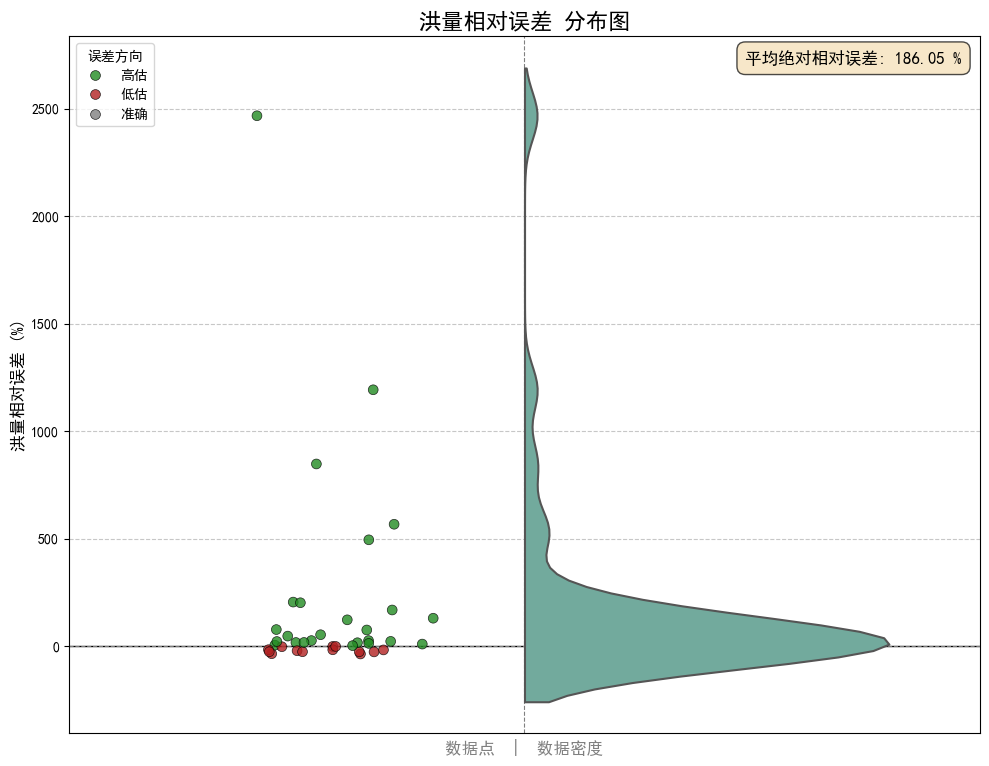


--- 正在生成 洪峰相对误差 分布雨云图 ---


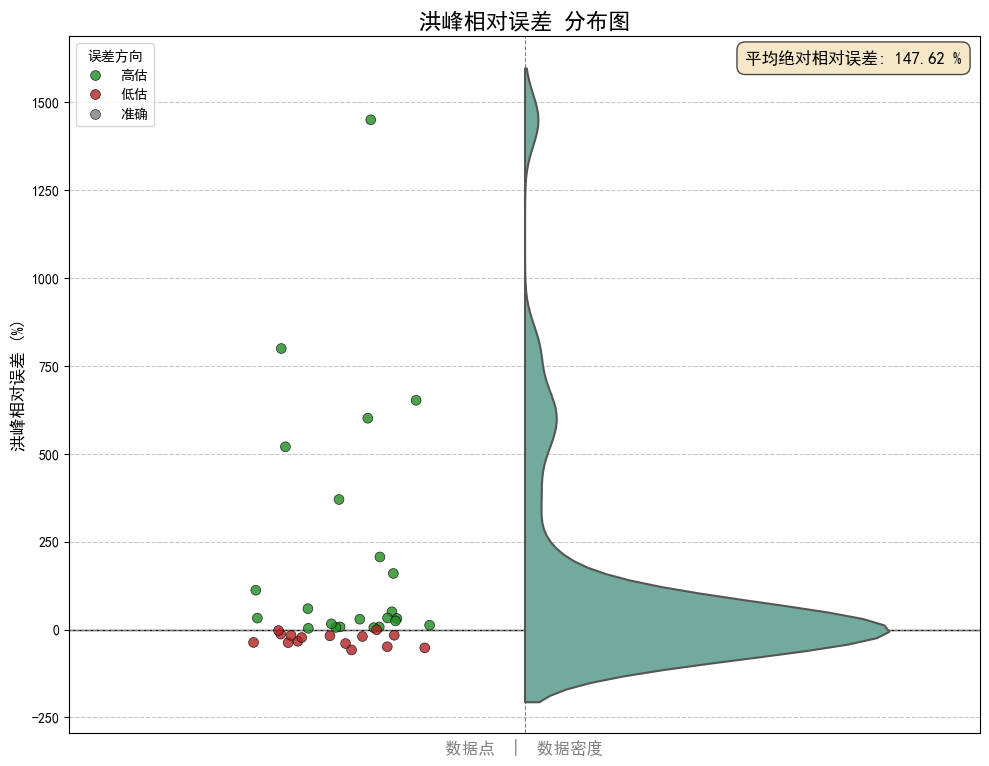

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 绘图函数 ---
def plot_error_raincloud(data_rel, feature_name, palette):
    """
    为给定的误差数据绘制雨云图。
    - data_rel: 带正负号的相对误差序列 (Pandas Series)。
    - feature_name: 图表标题中使用的特征名称 (e.g., '洪量相对误差')。
    - palette: 用于区分正负误差的调色板。
    """
    if data_rel.empty:
        print(f"警告: 特征 '{feature_name}' 没有有效数据，无法绘图。")
        return

    # 准备用于绘图的DataFrame
    df_plot = pd.DataFrame({'rel_error': data_rel})
    df_plot['误差方向'] = np.sign(df_plot['rel_error']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})

    # --- 开始绘图 ---
    fig, ax = plt.subplots(figsize=(10, 8))

    # 1. 绘制小提琴图 (分布曲线)
    sns.violinplot(y='rel_error', data=df_plot, ax=ax, color="#69b3a2", 
                   inner=None, linewidth=1.5, bw_adjust=0.5, zorder=5)
    
    # 将小提琴图变为半边
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.PolyCollection):
            path = collection.get_paths()[0]
            vertices = path.vertices
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    # 2. 绘制散点图
    x_scatter = -0.2 + (np.random.rand(len(df_plot)) * 0.2 - 0.1)
    sns.scatterplot(x=x_scatter, y='rel_error', data=df_plot, ax=ax, 
                    hue='误差方向', hue_order=['高估', '低估', '准确'], palette=palette, 
                    s=50, alpha=0.8, edgecolor='black', linewidth=0.5, zorder=10)
                  
    # 3. 计算并准备平均绝对相对误差文本
    mean_abs_rel_error = df_plot['rel_error'].abs().mean()
    stats_text = f"平均绝对相对误差: {mean_abs_rel_error:.2f} %"
    
    # 4. 在图中标注文本
    props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.7)
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    # 5. 美化图表
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1, zorder=0)
    ax.set_ylabel(f"{feature_name} (%)", fontsize=12)
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray')
    ax.set_title(f"{feature_name} 分布图", fontsize=16)
    ax.set_xticks([])
    ax.set_xlim(-0.5, 0.5)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='误差方向', loc='upper left')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# --- 主程序 ---
if __name__ == "__main__":
    # 1. 定义要读取的文件路径
    csv_filepath = "shared_uh_evaluation_report.csv"
    
    # 2. 读取CSV文件
    try:
        df_report = pd.read_csv(csv_filepath)
        print(f"成功读取文件: {csv_filepath}")
        print("文件内容预览:")
        print(df_report.head())
    except FileNotFoundError:
        print(f"错误: 文件 '{csv_filepath}' 未找到。请确保文件与脚本在同一目录下，或提供完整路径。")
        exit()
    except Exception as e:
        print(f"读取文件时发生错误: {e}")
        exit()

    # 3. 定义要绘图的列和样式
    error_features_to_plot = {
        "洪量相对误差(%)": "洪量相对误差",
        "洪峰相对误差(%)": "洪峰相对误差"
    }
    
    # 定义颜色: 绿色代表正值(高估), 红色代表负值(低估)
    error_palette = {'高估': 'forestgreen', '低估': 'firebrick', '准确': 'gray'}

    # 4. 循环为每个误差指标绘图
    for col_name, title_name in error_features_to_plot.items():
        if col_name in df_report.columns:
            print(f"\n--- 正在生成 {title_name} 分布雨云图 ---")
            # 提取数据并移除空值
            plot_data = df_report[col_name].dropna()
            
            if not plot_data.empty:
                plot_error_raincloud(
                    data_rel=plot_data,
                    feature_name=title_name,
                    palette=error_palette
                )
            else:
                print(f"警告: 列 '{col_name}' 中没有有效的数值数据。")
        else:
            print(f"错误: CSV文件中未找到列 '{col_name}'。")

## 只画NSE正的

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 绘图函数 ---
def plot_error_raincloud(data_rel, feature_name, palette, subset_description):
    """
    为给定的误差数据绘制雨云图。
    - data_rel: 带正负号的相对误差序列 (Pandas Series)。
    - feature_name: 图表标题中使用的特征名称。
    - palette: 用于区分正负误差的调色板。
    - subset_description: 用于图表标题的子集描述。
    """
    if data_rel.empty:
        print(f"警告: 特征 '{feature_name}' 在子集 '{subset_description}' 中没有有效数据，无法绘图。")
        return

    # 准备用于绘图的DataFrame
    df_plot = pd.DataFrame({'rel_error': data_rel})
    df_plot['误差方向'] = np.sign(df_plot['rel_error']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})

    # --- 开始绘图 ---
    fig, ax = plt.subplots(figsize=(10, 8))

    # 1. 绘制小提琴图
    sns.violinplot(y='rel_error', data=df_plot, ax=ax, color="#69b3a2", 
                   inner=None, linewidth=1.5, bw_adjust=0.5, zorder=5)
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.PolyCollection):
            path = collection.get_paths()[0]
            vertices = path.vertices
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    # 2. 绘制散点图
    x_scatter = -0.2 + (np.random.rand(len(df_plot)) * 0.2 - 0.1)
    sns.scatterplot(x=x_scatter, y='rel_error', data=df_plot, ax=ax, 
                    hue='误差方向', hue_order=['高估', '低估', '准确'], palette=palette, 
                    s=60, alpha=0.9, edgecolor='black', linewidth=0.7, zorder=10)
                  
    # 3. 计算并准备平均绝对相对误差文本
    mean_abs_rel_error = df_plot['rel_error'].abs().mean()
    stats_text = f"平均绝对相对误差: {mean_abs_rel_error:.2f} %"
    
    # 4. 在图中标注文本
    props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    # 5. 美化图表
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2, zorder=0)
    ax.set_ylabel(f"{feature_name} (%)", fontsize=12)
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray')
    ax.set_title(f"合格事件 (NSE≥0) 的 {feature_name} 分布图", fontsize=16)
    ax.set_xticks([])
    ax.set_xlim(-0.5, 0.5)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='误差方向', loc='upper left')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# --- 主程序 ---
if __name__ == "__main__":
    # 1. 定义要读取的文件路径
    csv_filepath = "shared_uh_evaluation_report.csv"
    
    # 2. 读取CSV文件
    try:
        df_report = pd.read_csv(csv_filepath)
        print(f"成功读取文件: {csv_filepath}")
    except FileNotFoundError:
        print(f"错误: 文件 '{csv_filepath}' 未找到。请确保文件与脚本在同一目录下，或提供完整路径。")
        exit()
    except Exception as e:
        print(f"读取文件时发生错误: {e}")
        exit()

    # 3. 检查必要的列是否存在
    required_cols = ['NSE', '洪量相对误差(%)', '洪峰相误(%)']
    if not all(col in df_report.columns for col in required_cols):
        print(f"错误: CSV文件中缺少必要的列。需要: {required_cols}")
        exit()

    # 4. 筛选出 NSE >= 0 的数据
    df_good_nse = df_report[df_report['NSE'] >= 0].copy()
    num_good_nse_events = len(df_good_nse)
    
    if num_good_nse_events == 0:
        print("\n数据中没有NSE大于或等于0的洪水事件，无法生成图表。")
        exit()
        
    print(f"\n已筛选出 {num_good_nse_events} 场 NSE >= 0 的洪水事件进行可视化。")
    
    # 5. 定义要绘图的列和样式
    error_features_to_plot = {
        "洪量相对误差(%)": "洪量相对误差",
        "洪峰相误(%)": "洪峰相对误差"
    }
    
    # 定义颜色: 绿色代表正值(高估), 红色代表负值(低估)
    error_palette = {'高估': 'forestgreen', '低估': 'firebrick', '准确': 'gray'}

    # 6. 循环为每个误差指标绘图
    for col_name, title_name in error_features_to_plot.items():
        if col_name in df_good_nse.columns:
            # 提取筛选后的数据并移除空值
            plot_data = df_good_nse[col_name].dropna()
            
            if not plot_data.empty:
                print(f"\n--- 正在生成 {title_name} 分布雨云图 (基于{num_good_nse_events}个NSE≥0的事件) ---")
                plot_error_raincloud(
                    data_rel=plot_data,
                    feature_name=title_name,
                    palette=error_palette,
                    subset_description=f"仅限 {num_good_nse_events} 个 NSE≥0 的事件"
                )
            else:
                print(f"警告: 列 '{col_name}' 在NSE≥0的事件中没有有效的数值数据。")
        else:
            print(f"错误: CSV文件中未找到列 '{col_name}'。")

SyntaxError: invalid character '，' (U+FF0C) (3771364501.py, line 58)

### 根据洪量分三类 指标图

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 全局常量 ---
R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数：数据预处理 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    """
    读取并处理单个洪水事件，并计算其关键水文特征。
    如果数据不满足处理条件，则返回 None。
    """
    try:
        # 尝试多种编码方式读取CSV文件
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None

    time_col = '时间'; net_rain_col = '泰森多边形面雨量'; direct_runoff_col = '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None

    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    
    # --- 这里是补充回来的关键变量定义 ---
    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain):
        if r_val > 1e-6:
            first_rain_idx = i
            has_effective_rain = True
            break
    if not has_effective_rain: return None

    last_rain_idx = len(net_rain) - 1
    for i in range(len(net_rain) - 1, first_rain_idx - 1, -1):
        if net_rain[i] > 1e-6:
            last_rain_idx = i
            break
    # --- 补充结束 ---
            
    if np.sum(net_rain) < 1e-6: return None
    
    runoff_indices = np.where(direct_runoff > 1e-6)[0]
    if len(runoff_indices) < 2: return None
    
    DELTA_T_HOURS = 3.0 # 假设时段长，可以作为参数传入或全局定义
    delta_t_seconds = DELTA_T_HOURS * 3600.0
    
    runoff_duration_hours = (runoff_indices[-1] - runoff_indices[0] + 1) * DELTA_T_HOURS
    
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    t_peak_flow_idx = np.argmax(direct_runoff)
    
    runoff_volume_m3 = np.sum(direct_runoff) * delta_t_seconds
    total_net_rain = np.sum(net_rain)
    t_peak_rain_idx = np.argmax(net_rain)
    lag_time_hours = (t_peak_flow_idx - t_peak_rain_idx) * DELTA_T_HOURS

    # 现在 return 语句中的变量都是已定义的
    return {
        "P_eff": net_rain[first_rain_idx:last_rain_idx+1], 
        "Q_obs_eff": direct_runoff[first_rain_idx:], 
        "m_eff": len(net_rain[first_rain_idx:last_rain_idx+1]), 
        "n_specific": len(direct_runoff[first_rain_idx:]) - len(net_rain[first_rain_idx:last_rain_idx+1]) + 1, 
        "filepath": csv_filepath, 
        "peak_obs": peak_flow
    }

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh_for_category):
    total_fit_loss = 0
    if len(U_params) != common_n_uh_for_category: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

def optimize_uh_for_group(events_in_group, group_name, weights):
    # ... (与之前版本完全相同) ...
    print(f"\n--- 正在为组 '{group_name}' 优化特征单位线 ({len(events_in_group)} 场) ---")
    if len(events_in_group) < 3:
        print("事件数量过少，跳过优化。")
        return None
    n_specifics = [d["n_specific"] for d in events_in_group if d["n_specific"] > 0]
    if not n_specifics: return None
    n_uh_group = int(np.max(n_specifics))
    if n_uh_group <= 1: n_uh_group = max(3, n_uh_group if n_uh_group > 0 else 3)
    print(f"  单位线长度: {n_uh_group}")
    data_for_opt_group = []
    for event in events_in_group:
        P_eff, Q_obs_eff, m_eff = event["P_eff"], event["Q_obs_eff"], event["m_eff"]
        target_q_len = m_eff + n_uh_group - 1
        if target_q_len < 0: target_q_len = 0
        Q_obs_for_opt = np.zeros(target_q_len)
        len_to_copy = min(len(Q_obs_eff), target_q_len)
        Q_obs_for_opt[:len_to_copy] = Q_obs_eff[:len_to_copy]
        data_for_opt_group.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt})
    U_initial = np.zeros(n_uh_group)
    bounds = [(0, None) for _ in range(n_uh_group)]
    smoothing, peak_penalty = weights['smoothing_factor'], weights['peak_violation_weight']
    apply_penalty = n_uh_group > 2
    print(f"  使用权重: 平滑={smoothing}, 单峰罚={peak_penalty if apply_penalty else 'N/A'}")
    result_uh = minimize(objective_function_multi_event, U_initial, args=(data_for_opt_group, R_UH, smoothing, peak_penalty, apply_penalty, n_uh_group), method='L-BFGS-B', bounds=bounds, options={'disp': False, 'maxiter': 500})
    U_optimized = result_uh.x if (result_uh.success or result_uh.status in [0,2]) else None
    status_message = "成功" if (result_uh.success or result_uh.status in [0,2]) else "可能未收敛"
    print(f"  优化{status_message}")
    return U_optimized

# --- 新增的绘图辅助函数 ---
def plot_nse_boxplot(data, category_name):
    plt.figure(figsize=(8, 8))
    sns.boxplot(y=data, color="skyblue", width=0.3, linewidth=1.5)
    sns.stripplot(y=data, color="royalblue", jitter=0.1, alpha=0.7)
    plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1.5, label='合格线 (0.5)')
    plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
    plt.title(f'类别 "{category_name}" - NSE 分布图', fontsize=16)
    plt.ylabel('NSE 值', fontsize=12)
    plt.xticks([])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_error_raincloud(data, hue_data, feature_name, unit, category_name):
    fig, ax = plt.subplots(figsize=(10, 8))
    palette = {'高估': 'forestgreen', '低估': 'firebrick', '准确': 'gray'}
    
    sns.violinplot(y=data, ax=ax, color="#69b3a2", inner=None, linewidth=1.5, bw_adjust=0.5, zorder=5)
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.PolyCollection):
            path = collection.get_paths()[0]
            vertices = path.vertices
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    x_scatter = -0.2 + (np.random.rand(len(data)) * 0.2 - 0.1)
    sns.scatterplot(x=x_scatter, y=data, ax=ax, hue=hue_data, palette=palette, s=50, alpha=0.8, edgecolor='black', linewidth=0.5, zorder=10)
                  
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_ylabel(f"{feature_name} ({unit})", fontsize=12)
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray')
    ax.set_title(f'类别 "{category_name}" - {feature_name}分布图', fontsize=16)
    ax.set_xticks([])
    ax.set_xlim(-0.5, 0.5)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='误差方向')
    plt.tight_layout()
    plt.show()

# --- 主程序 ---
# 1. 数据预处理
data_folder = "data_source/" 
csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
print(f"找到 {len(csv_files)} 个CSV文件...")
all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
if not all_events_processed_data: exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

# 2. 洪水事件分类
event_peaks = [data['peak_obs'] for data in all_events_processed_data if data['peak_obs'] > 0]
if not event_peaks: exit()
threshold_low = np.percentile(event_peaks, 33.3)
threshold_high = np.percentile(event_peaks, 66.6)
categorized_events = {'small': [], 'medium': [], 'large': []}
for event_data in all_events_processed_data:
    peak = event_data['peak_obs']
    if peak <= threshold_low: categorized_events['small'].append(event_data)
    elif peak <= threshold_high: categorized_events['medium'].append(event_data)
    else: categorized_events['large'].append(event_data)
print("\n各类别洪水事件数量:")
for category, events in categorized_events.items(): print(f"  {category.capitalize()} 洪水: {len(events)} 场")

# 3. 为每个类别推求特征单位线
category_weights = {
    'small':  {'smoothing_factor': 0.1, 'peak_violation_weight': 100.0},
    'medium': {'smoothing_factor': 0.5, 'peak_violation_weight': 500.0},
    'large':  {'smoothing_factor': 1.0, 'peak_violation_weight': 1000.0}
}
optimized_uhs = {}
for category_name, events in categorized_events.items():
    weights = category_weights.get(category_name, {})
    optimized_uhs[category_name] = optimize_uh_for_group(events, category_name, weights)

# 4. 评估并为每个类别绘制分布图
for category_name, events_in_category in categorized_events.items():
    U_optimized_cat = optimized_uhs.get(category_name)
    if U_optimized_cat is None:
        print(f"\n类别 '{category_name}' 没有可用的特征单位线，跳过评估和绘图。")
        continue

    # 计算该类别内所有事件的评估指标
    category_event_analysis = []
    for event_data in events_in_category:
        P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
        Q_sim_event_full = convolve_uh(P_event, U_optimized_cat, R_UH)
        Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
        
        metrics = {"NSE": np.nan, "洪量相误(%)": np.nan, "洪峰相误(%)": np.nan}
        if len(Q_obs_event_full) > 0 and len(Q_sim_event_compare) == len(Q_obs_event_full):
            mean_obs = np.mean(Q_obs_event_full)
            den_nse = np.sum((Q_obs_event_full - mean_obs)**2)
            if den_nse == 0: nse = 1.0 if np.allclose(Q_sim_event_compare, Q_obs_event_full) else -np.inf
            else: nse = 1 - (np.sum((Q_obs_event_full - Q_sim_event_compare)**2) / den_nse)
            metrics["NSE"] = nse
            vol_obs = np.sum(Q_obs_event_full) * delta_t_seconds
            vol_sim = np.sum(Q_sim_event_compare) * delta_t_seconds
            if vol_obs > 1e-6: metrics["洪量相误(%)"] = ((vol_sim - vol_obs) / vol_obs) * 100.0
            peak_obs = np.max(Q_obs_event_full)
            if peak_obs > 1e-6: metrics["洪峰相误(%)"] = ((np.max(Q_sim_event_compare) - peak_obs) / peak_obs) * 100.0
        category_event_analysis.append(metrics)

    # 转换为DataFrame用于绘图
    df_category_plot = pd.DataFrame(category_event_analysis).dropna()
    if df_category_plot.empty:
        print(f"类别 '{category_name}' 没有可供评估的有效事件。")
        continue
        
    df_category_plot['洪量误差方向'] = np.sign(df_category_plot['洪量相误(%)']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})
    df_category_plot['洪峰误差方向'] = np.sign(df_category_plot['洪峰相误(%)']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})

    print(f"\n--- 正在为类别 '{category_name.capitalize()}' 生成评估分布图 ---")
    
    # 绘制NSE箱式图
    plot_nse_boxplot(df_category_plot['NSE'], category_name.capitalize())
    
    # 绘制洪量误差雨云图
    plot_error_raincloud(
        data=df_category_plot['洪量相误(%)'],
        hue_data=df_category_plot['洪量误差方向'],
        feature_name="洪量相对误差",
        unit=r'\%',
        category_name=category_name.capitalize(),
    )

    # 绘制洪峰误差雨云图
    plot_error_raincloud(
        data=df_category_plot['洪峰相误(%)'],
        hue_data=df_category_plot['洪峰误差方向'],
        feature_name="洪峰相对误差",
        unit=r'\%',
        category_name=category_name.capitalize(),
    )

找到 38 个CSV文件...
成功预处理 38 场洪水事件。

各类别洪水事件数量:
  Small 洪水: 13 场
  Medium 洪水: 12 场
  Large 洪水: 13 场

--- 正在为组 'small' 优化特征单位线 (13 场) ---
  单位线长度: 49
  使用权重: 平滑=0.1, 单峰罚=100.0


NameError: name 'minimize' is not defined

### 三分类 雨云图 添加平均相对误差

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os
from scipy.optimize import minimize # 确保导入 minimize

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 全局常量 ---
R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数：数据预处理 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    """
    读取并处理单个洪水事件，并计算其关键水文特征。
    如果数据不满足处理条件，则返回 None。
    """
    try:
        # 尝试多种编码方式读取CSV文件
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError: continue
        if df is None:
            print(f"警告: 无法解码文件 {os.path.basename(csv_filepath)}。")
            return None
    except Exception as e:
        print(f"警告: 读取文件 {os.path.basename(csv_filepath)} 时出错: {e}")
        return None

    time_col, net_rain_col, direct_runoff_col = '时间', '泰森多边形面雨量', '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]):
        print(f"警告: 文件 {os.path.basename(csv_filepath)} 缺少必要的列。")
        return None

    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values

    # --- 关键变量定义 ---
    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain):
        if r_val > 1e-6:
            first_rain_idx = i
            has_effective_rain = True
            break
    if not has_effective_rain: return None

    last_rain_idx = len(net_rain) - 1
    for i in range(len(net_rain) - 1, first_rain_idx - 1, -1):
        if net_rain[i] > 1e-6:
            last_rain_idx = i
            break
            
    if np.sum(net_rain) < 1e-6: return None
    
    runoff_indices = np.where(direct_ runoff > 1e-6)[0]
    if len(runoff_indices) < 2: return None
    
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    
    # 返回一个包含所有必要信息的字典
    return {
        "P_eff": net_rain[first_rain_idx:last_rain_idx+1], 
        "Q_obs_eff": direct_runoff[first_rain_idx:], 
        "m_eff": len(net_rain[first_rain_idx:last_rain_idx+1]), 
        "n_specific": len(direct_runoff[first_rain_idx:]) - len(net_rain[first_rain_idx:last_rain_idx+1]) + 1, 
        "filepath": csv_filepath, 
        "peak_obs": peak_flow
    }

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    m_p, n_u = len(P), len(U)
    len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh_for_category):
    total_fit_loss = 0
    if len(U_params) != common_n_uh_for_category: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

def optimize_uh_for_group(events_in_group, group_name, weights):
    print(f"\n--- 正在为组 '{group_name}' 优化特征单位线 ({len(events_in_group)} 场) ---")
    if len(events_in_group) < 3:
        print("事件数量过少（少于3场），跳过优化。")
        return None
    n_specifics = [d["n_specific"] for d in events_in_group if d["n_specific"] > 0]
    if not n_specifics: 
        print("无有效n_specific值，跳过优化。")
        return None
    n_uh_group = int(np.max(n_specifics))
    if n_uh_group <= 1: n_uh_group = max(3, n_uh_group if n_uh_group > 0 else 3)
    print(f"  单位线长度 (n_uh): {n_uh_group}")
    data_for_opt_group = []
    for event in events_in_group:
        P_eff, Q_obs_eff, m_eff = event["P_eff"], event["Q_obs_eff"], event["m_eff"]
        target_q_len = m_eff + n_uh_group - 1
        if target_q_len < 0: target_q_len = 0
        Q_obs_for_opt = np.zeros(target_q_len)
        len_to_copy = min(len(Q_obs_eff), target_q_len)
        Q_obs_for_opt[:len_to_copy] = Q_obs_eff[:len_to_copy]
        data_for_opt_group.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt})
    U_initial = np.zeros(n_uh_group)
    bounds = [(0, None) for _ in range(n_uh_group)]
    smoothing, peak_penalty = weights['smoothing_factor'], weights['peak_violation_weight']
    apply_penalty = n_uh_group > 2
    print(f"  使用权重: 平滑={smoothing}, 单峰罚={peak_penalty if apply_penalty else 'N/A'}")
    result_uh = minimize(objective_function_multi_event, U_initial, args=(data_for_opt_group, R_UH, smoothing, peak_penalty, apply_penalty, n_uh_group), method='L-BFGS-B', bounds=bounds, options={'disp': False, 'maxiter': 500})
    U_optimized = result_uh.x if (result_uh.success or result_uh.status in [0,2]) else None
    status_message = "成功" if (result_uh.success or result_uh.status in [0,2]) else "可能未收敛"
    print(f"  优化{status_message}")
    return U_optimized

# --- 绘图辅助函数 ---
def plot_nse_boxplot(data, category_name):
    plt.figure(figsize=(8, 8))
    sns.boxplot(y=data, color="skyblue", width=0.3, linewidth=1.5)
    sns.stripplot(y=data, color="royalblue", jitter=0.1, alpha=0.7)
    plt.axhline(y=0.5, color='green', linestyle='--', linewidth=1.5, label='合格线 (0.5)')
    plt.axhline(y=0, color='black', linestyle=':', linewidth=1)
    plt.title(f'类别 "{category_name}" - NSE 分布图', fontsize=16)
    plt.ylabel('NSE 值', fontsize=12)
    plt.xticks([])
    plt.legend()
    plt.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# --- MODIFIED: 新的雨云图绘制函数，增加了 mean_abs_error 参数 ---
def plot_error_raincloud(data, hue_data, feature_name, unit, category_name, mean_abs_error):
    """
    绘制带有平均绝对误差指标的雨云图。
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    palette = {'高估': 'forestgreen', '低估': 'firebrick', '准确': 'gray'}
    
    # 绘制小提琴图部分
    sns.violinplot(y=data, ax=ax, color="#69b3a2", inner=None, linewidth=1.5, bw_adjust=0.5, zorder=5)
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.PolyCollection):
            path = collection.get_paths()[0]
            vertices = path.vertices
            # 确保小提琴图不会画到x轴负半轴
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    # 绘制散点图部分
    x_scatter = -0.2 + (np.random.rand(len(data)) * 0.2 - 0.1)
    sns.scatterplot(x=x_scatter, y=data, ax=ax, hue=hue_data, palette=palette, s=50, alpha=0.8, edgecolor='black', linewidth=0.5, zorder=10)
                  
    # --- 新增功能：在图上显示平均绝对相对误差 ---
    unit_display = unit.replace(r'\%', '%')
    text_str = f'平均绝对相对误差: {mean_abs_error:.2f}{unit_display}'
    ax.text(0.97, 0.97, text_str,
            transform=ax.transAxes,
            fontsize=12,
            fontweight='bold',
            verticalalignment='top',
            horizontalalignment='right',
            bbox=dict(boxstyle='round,pad=0.5', fc='wheat', alpha=0.7))

    # --- 图表美化 ---
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.set_ylabel(f"{feature_name} ({unit})", fontsize=12)
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray')
    ax.set_title(f'类别 "{category_name}" - {feature_name}分布图', fontsize=16)
    ax.set_xticks([])
    ax.set_xlim(-0.5, 0.5)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='误差方向')
    plt.tight_layout()
    plt.show()

# --- 主程序 ---
# 1. 数据预处理
data_folder = "data_source/" 
if not os.path.exists(data_folder):
    print(f"错误：数据文件夹 '{data_folder}' 不存在。请创建该文件夹并放入CSV文件。")
    exit()
csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
if not csv_files:
    print(f"警告：在 '{data_folder}' 中未找到任何CSV文件。")
    exit()
print(f"找到 {len(csv_files)} 个CSV文件...")
all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
if not all_events_processed_data:
    print("错误：没有成功处理任何洪水事件数据，程序终止。")
    exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

# 2. 洪水事件分类
event_peaks = [data['peak_obs'] for data in all_events_processed_data if data['peak_obs'] > 0]
if not event_peaks:
    print("错误：所有已处理事件的洪峰流量均为0，无法进行分类，程序终止。")
    exit()
threshold_low = np.percentile(event_peaks, 33.3)
threshold_high = np.percentile(event_peaks, 66.6)
categorized_events = {'small': [], 'medium': [], 'large': []}
for event_data in all_events_processed_data:
    peak = event_data['peak_obs']
    if peak <= threshold_low: categorized_events['small'].append(event_data)
    elif peak <= threshold_high: categorized_events['medium'].append(event_data)
    else: categorized_events['large'].append(event_data)
print("\n各类别洪水事件数量:")
for category, events in categorized_events.items(): print(f"  {category.capitalize()} 洪水: {len(events)} 场")

# 3. 为每个类别推求特征单位线
category_weights = {
    'small':  {'smoothing_factor': 0.1, 'peak_violation_weight': 100.0},
    'medium': {'smoothing_factor': 0.5, 'peak_violation_weight': 500.0},
    'large':  {'smoothing_factor': 1.0, 'peak_violation_weight': 1000.0}
}
optimized_uhs = {}
for category_name, events in categorized_events.items():
    weights = category_weights.get(category_name, {'smoothing_factor': 0.5, 'peak_violation_weight': 500.0})
    optimized_uhs[category_name] = optimize_uh_for_group(events, category_name, weights)

# 4. 评估并为每个类别绘制分布图
for category_name, events_in_category in categorized_events.items():
    U_optimized_cat = optimized_uhs.get(category_name)
    if U_optimized_cat is None:
        print(f"\n类别 '{category_name}' 没有可用的特征单位线，跳过评估和绘图。")
        continue

    # 计算该类别内所有事件的评估指标
    category_event_analysis = []
    for event_data in events_in_category:
        P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
        Q_sim_event_full = convolve_uh(P_event, U_optimized_cat, R_UH)
        
        # 确保比较长度一致
        len_compare = len(Q_obs_event_full)
        Q_sim_event_compare = Q_sim_event_full[:len_compare]
        
        metrics = {"NSE": np.nan, "洪量相误(%)": np.nan, "洪峰相误(%)": np.nan}
        if len_compare > 0 and len(Q_sim_event_compare) == len_compare:
            mean_obs = np.mean(Q_obs_event_full)
            den_nse = np.sum((Q_obs_event_full - mean_obs)**2)
            if den_nse < 1e-9: 
                nse = 1.0 if np.allclose(Q_sim_event_compare, Q_obs_event_full) else -np.inf
            else: 
                nse = 1 - (np.sum((Q_obs_event_full - Q_sim_event_compare)**2) / den_nse)
            
            metrics["NSE"] = nse
            
            vol_obs = np.sum(Q_obs_event_full) * delta_t_seconds
            vol_sim = np.sum(Q_sim_event_compare) * delta_t_seconds
            if vol_obs > 1e-6: 
                metrics["洪量相误(%)"] = ((vol_sim - vol_obs) / vol_obs) * 100.0
            
            peak_obs = np.max(Q_obs_event_full)
            peak_sim = np.max(Q_sim_event_compare) if len(Q_sim_event_compare) > 0 else 0
            if peak_obs > 1e-6: 
                metrics["洪峰相误(%)"] = ((peak_sim - peak_obs) / peak_obs) * 100.0
                
        category_event_analysis.append(metrics)

    # 转换为DataFrame用于绘图
    df_category_plot = pd.DataFrame(category_event_analysis).dropna()
    if df_category_plot.empty:
        print(f"类别 '{category_name}' 没有可供评估的有效事件。")
        continue
        
    df_category_plot['洪量误差方向'] = np.sign(df_category_plot['洪量相误(%)']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})
    df_category_plot['洪峰误差方向'] = np.sign(df_category_plot['洪峰相误(%)']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})

    print(f"\n--- 正在为类别 '{category_name.capitalize()}' 生成评估分布图 ---")
    
    # 绘制NSE箱式图
    plot_nse_boxplot(df_category_plot['NSE'], category_name.capitalize())
    
    # --- NEW: 计算平均绝对相对误差 ---
    mean_abs_volume_error = df_category_plot['洪量相误(%)'].abs().mean()
    mean_abs_peak_error = df_category_plot['洪峰相误(%)'].abs().mean()

    # 绘制洪量误差雨云图
    plot_error_raincloud(
        data=df_category_plot['洪量相误(%)'],
        hue_data=df_category_plot['洪量误差方向'],
        feature_name="洪量相对误差",
        unit=r'\%',
        category_name=category_name.capitalize(),
        mean_abs_error=mean_abs_volume_error  # 传递新计算的指标
    )

    # 绘制洪峰误差雨云图
    plot_error_raincloud(
        data=df_category_plot['洪峰相误(%)'],
        hue_data=df_category_plot['洪峰误差方向'],
        feature_name="洪峰相对误差",
        unit=r'\%',
        category_name=category_name.capitalize(),
        mean_abs_error=mean_abs_peak_error  # 传递新计算的指标
    )

SyntaxError: invalid syntax (625232993.py, line 70)

### 三分类指标

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os
from scipy.optimize import minimize # <--- 在这里添加这一行

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")
# ... 后续代码保持不变 ...

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 全局常量 ---
R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数：数据预处理 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    # ... (与之前版本完全相同) ...
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None;
        for enc in encodings_to_try:
            try: df = pd.read_csv(csv_filepath, encoding=enc); break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None
    time_col, net_rain_col, direct_runoff_col = '时间', '泰森多边形面雨量', '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None
    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    if np.sum(net_rain) < 1e-6: return None
    runoff_indices = np.where(direct_runoff > 1e-6)[0]
    if len(runoff_indices) < 2: return None
    
    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain):
        if r_val > 1e-6: first_rain_idx, has_effective_rain = i, True; break
    if not has_effective_rain: return None
    last_rain_idx = len(net_rain) - 1
    for i in range(len(net_rain) - 1, first_rain_idx - 1, -1):
        if net_rain[i] > 1e-6: last_rain_idx = i; break
        
    peak_flow = np.max(direct_runoff)
    if peak_flow < 1e-6: return None
    
    return {"P_eff": net_rain[first_rain_idx:last_rain_idx+1], 
            "Q_obs_eff": direct_runoff[first_rain_idx:], 
            "m_eff": len(net_rain[first_rain_idx:last_rain_idx+1]), 
            "n_specific": len(direct_runoff[first_rain_idx:]) - len(net_rain[first_rain_idx:last_rain_idx+1]) + 1, 
            "filepath": csv_filepath, 
            "peak_obs": peak_flow}

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    # ... (与之前版本完全相同) ...
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh_for_category):
    # ... (与之前版本完全相同) ...
    total_fit_loss = 0
    if len(U_params) != common_n_uh_for_category: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

def optimize_uh_for_group(events_in_group, group_name, weights):
    # ... (与之前版本完全相同) ...
    print(f"\n--- 正在为组 '{group_name}' 优化特征单位线 ({len(events_in_group)} 场) ---")
    if len(events_in_group) < 3:
        print("事件数量过少，跳过优化。")
        return None
    n_specifics = [d["n_specific"] for d in events_in_group if d["n_specific"] > 0]
    if not n_specifics: return None
    n_uh_group = int(np.max(n_specifics))
    if n_uh_group <= 1: n_uh_group = max(3, n_uh_group if n_uh_group > 0 else 3)
    print(f"  单位线长度: {n_uh_group}")
    data_for_opt_group = []
    for event in events_in_group:
        P_eff, Q_obs_eff, m_eff = event["P_eff"], event["Q_obs_eff"], event["m_eff"]
        target_q_len = m_eff + n_uh_group - 1
        if target_q_len < 0: target_q_len = 0
        Q_obs_for_opt = np.zeros(target_q_len)
        len_to_copy = min(len(Q_obs_eff), target_q_len)
        Q_obs_for_opt[:len_to_copy] = Q_obs_eff[:len_to_copy]
        data_for_opt_group.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt})
    U_initial = np.zeros(n_uh_group)
    bounds = [(0, None) for _ in range(n_uh_group)]
    smoothing, peak_penalty = weights['smoothing_factor'], weights['peak_violation_weight']
    apply_penalty = n_uh_group > 2
    print(f"  使用权重: 平滑={smoothing}, 单峰罚={peak_penalty if apply_penalty else 'N/A'}")
    result_uh = minimize(objective_function_multi_event, U_initial, args=(data_for_opt_group, R_UH, smoothing, peak_penalty, apply_penalty, n_uh_group), method='L-BFGS-B', bounds=bounds, options={'disp': False, 'maxiter': 500})
    U_optimized = result_uh.x if (result_uh.success or result_uh.status in [0,2]) else None
    status_message = "成功" if (result_uh.success or result_uh.status in [0,2]) else "可能未收敛"
    print(f"  优化{status_message}")
    return U_optimized

# --- 主程序 ---
# 1. & 2. 数据预处理和分类 (与之前相同)
data_folder = "data_source/" 
try:
    csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
    if not csv_files: exit()
except FileNotFoundError: exit()
all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
if not all_events_processed_data: exit()
print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

event_peaks = [data['peak_obs'] for data in all_events_processed_data if data['peak_obs'] > 0]
if not event_peaks: exit()
threshold_low = np.percentile(event_peaks, 33.3)
threshold_high = np.percentile(event_peaks, 66.6)
categorized_events = {'small': [], 'medium': [], 'large': []}
for event_data in all_events_processed_data:
    peak = event_data['peak_obs']
    if peak <= threshold_low: categorized_events['small'].append(event_data)
    elif peak <= threshold_high: categorized_events['medium'].append(event_data)
    else: categorized_events['large'].append(event_data)
print("\n各类别洪水事件数量:")
for category, events in categorized_events.items(): print(f"  {category.capitalize()} 洪水: {len(events)} 场")

# 3. 为每个类别推求特征单位线 (与之前相同)
category_weights = {
    'small':  {'smoothing_factor': 0.1, 'peak_violation_weight': 100.0},
    'medium': {'smoothing_factor': 0.5, 'peak_violation_weight': 500.0},
    'large':  {'smoothing_factor': 1.0, 'peak_violation_weight': 1000.0}
}
optimized_uhs = {}
for category_name, events in categorized_events.items():
    weights = category_weights.get(category_name, {})
    optimized_uhs[category_name] = optimize_uh_for_group(events, category_name, weights)

# --- 4. 评估并整合所有结果到 final_report_data 列表 ---
final_report_data = []

for category_name, events_in_category in categorized_events.items():
    U_optimized_cat = optimized_uhs.get(category_name)
    
    if U_optimized_cat is None:
        # 即使该类别没有优化出单位线，我们仍然可以记录这些事件
        for event_data in events_in_category:
            final_report_data.append({
                "文件名": os.path.basename(event_data["filepath"]),
                "所属类别": category_name,
                "NSE": np.nan,
                "洪量相对误差(%)": np.nan,
                "洪峰相对误差(%)": np.nan
            })
        continue

    # 使用该类别的特征单位线评估其内部所有事件
    for event_data in events_in_category:
        P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
        event_filename = os.path.basename(event_data["filepath"])
        Q_sim_event_full = convolve_uh(P_event, U_optimized_cat, R_UH)
        Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
        
        metrics = {
            "文件名": event_filename,
            "所属类别": category_name,
            "NSE": np.nan, 
            "洪量相对误差(%)": np.nan, 
            "洪峰相对误差(%)": np.nan
        }
        
        if len(Q_obs_event_full) > 0 and len(Q_sim_event_compare) == len(Q_obs_event_full):
            mean_obs = np.mean(Q_obs_event_full)
            den_nse = np.sum((Q_obs_event_full - mean_obs)**2)
            if den_nse == 0: 
                nse = 1.0 if np.allclose(Q_sim_event_compare, Q_obs_event_full) else -np.inf
            else: 
                nse = 1 - (np.sum((Q_obs_event_full - Q_sim_event_compare)**2) / den_nse)
            metrics["NSE"] = nse

            vol_obs = np.sum(Q_obs_event_full) * delta_t_seconds
            vol_sim = np.sum(Q_sim_event_compare) * delta_t_seconds
            if vol_obs > 1e-6: 
                metrics["洪量相对误差(%)"] = ((vol_sim - vol_obs) / vol_obs) * 100.0
            
            peak_obs = np.max(Q_obs_event_full)
            if peak_obs > 1e-6: 
                metrics["洪峰相对误差(%)"] = ((np.max(Q_sim_event_compare) - peak_obs) / peak_obs) * 100.0
        
        final_report_data.append(metrics)

# --- 5. 将最终结果转换为DataFrame，排序并保存到CSV文件 ---
if final_report_data:
    report_df = pd.DataFrame(final_report_data)
    # 按 "所属类别" 和 "NSE" 排序
    report_df_sorted = report_df.sort_values(by=["所属类别", "NSE"], ascending=[True, True]).reset_index(drop=True)

    output_csv_path = "categorized_uh_evaluation_report.csv"
    try:
        report_df_sorted.to_csv(output_csv_path, index=False, encoding='utf-8-sig', float_format='%.4f')
        print(f"\n✅ 完整的分类评估报告已成功保存到文件: {output_csv_path}")
    except Exception as e:
        print(f"\n❌ 保存最终报告到文件失败: {e}")

    # (可选) 在Notebook中打印预览
    print("\n--- 分类评估报告预览 (按类别和NSE排序) ---")
    pd.set_option('display.max_rows', 100) 
    pd.set_option('display.width', 120)      
    print(report_df_sorted)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.width')
else:
    print("\n没有生成任何评估结果。")

成功预处理 38 场洪水事件。

各类别洪水事件数量:
  Small 洪水: 13 场
  Medium 洪水: 12 场
  Large 洪水: 13 场

--- 正在为组 'small' 优化特征单位线 (13 场) ---
  单位线长度: 49
  使用权重: 平滑=0.1, 单峰罚=100.0
  优化成功

--- 正在为组 'medium' 优化特征单位线 (12 场) ---
  单位线长度: 51
  使用权重: 平滑=0.5, 单峰罚=500.0
  优化成功

--- 正在为组 'large' 优化特征单位线 (13 场) ---
  单位线长度: 55
  使用权重: 平滑=1.0, 单峰罚=1000.0
  优化成功

✅ 完整的分类评估报告已成功保存到文件: categorized_uh_evaluation_report.csv

--- 分类评估报告预览 (按类别和NSE排序) ---
             文件名    所属类别        NSE   洪量相对误差(%)   洪峰相对误差(%)
0   20170802.csv   large  -1.542320  166.326301   65.674927
1   19920901.csv   large   0.236829   77.102369   10.946969
2   20010816.csv   large   0.314777   33.428484   47.495275
3   19850818.csv   large   0.706831  -25.772412  -45.149393
4   19960729.csv   large   0.758263  -27.241626  -36.141804
5   19840615.csv   large   0.776712   26.281947   24.303685
6   19910721.csv   large   0.785359   11.878664   21.294783
7   19940815.csv   large   0.814776  -15.551438  -34.926373
8   20110808.csv   large   0.842368   18.58

d:\Anaconda\envs\condaenvironment\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.21.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


成功读取文件: categorized_uh_evaluation_report.csv
文件内容预览:
            文件名   所属类别     NSE  洪量相对误差(%)  洪峰相对误差(%)
0  20170802.csv  large -1.5423   166.3263    65.6749
1  19920901.csv  large  0.2368    77.1024    10.9470
2  20010816.csv  large  0.3148    33.4285    47.4953
3  19850818.csv  large  0.7068   -25.7724   -45.1494
4  19960729.csv  large  0.7583   -27.2416   -36.1418

--- 正在为类别 'Large' 生成评估分布图 ---


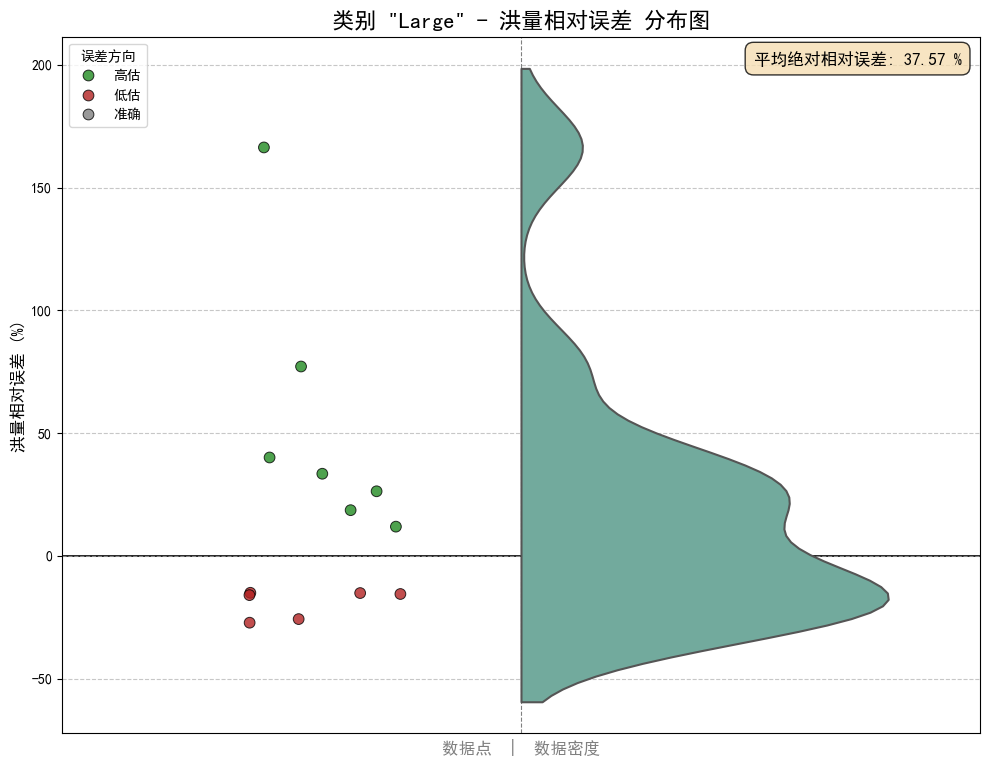

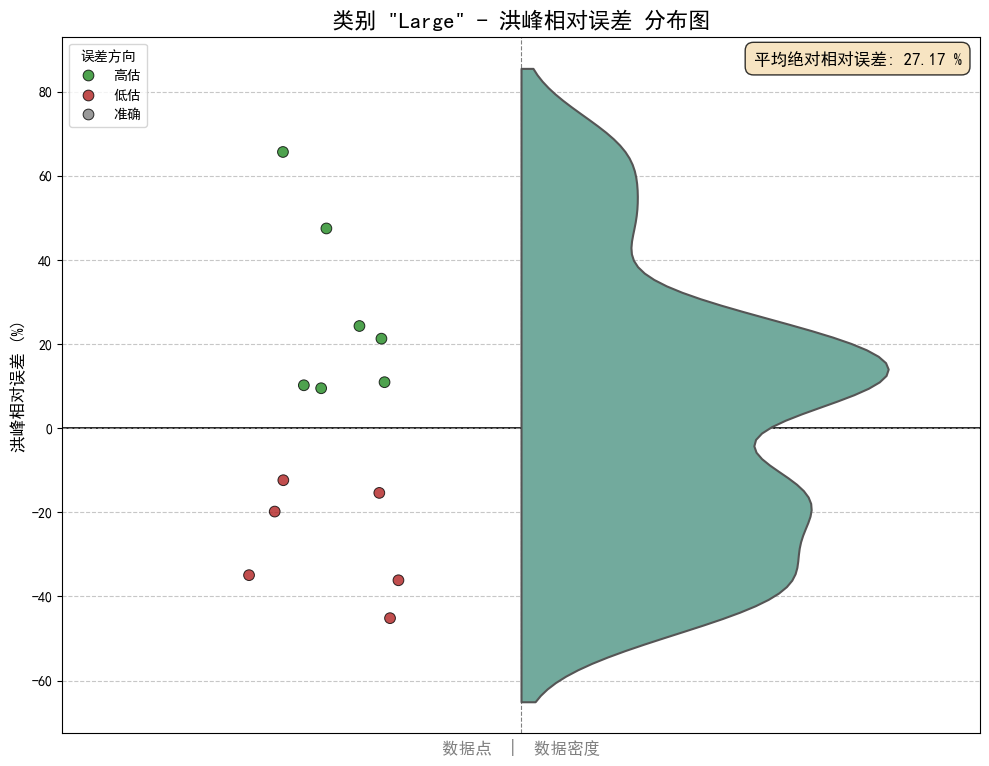


--- 正在为类别 'Medium' 生成评估分布图 ---


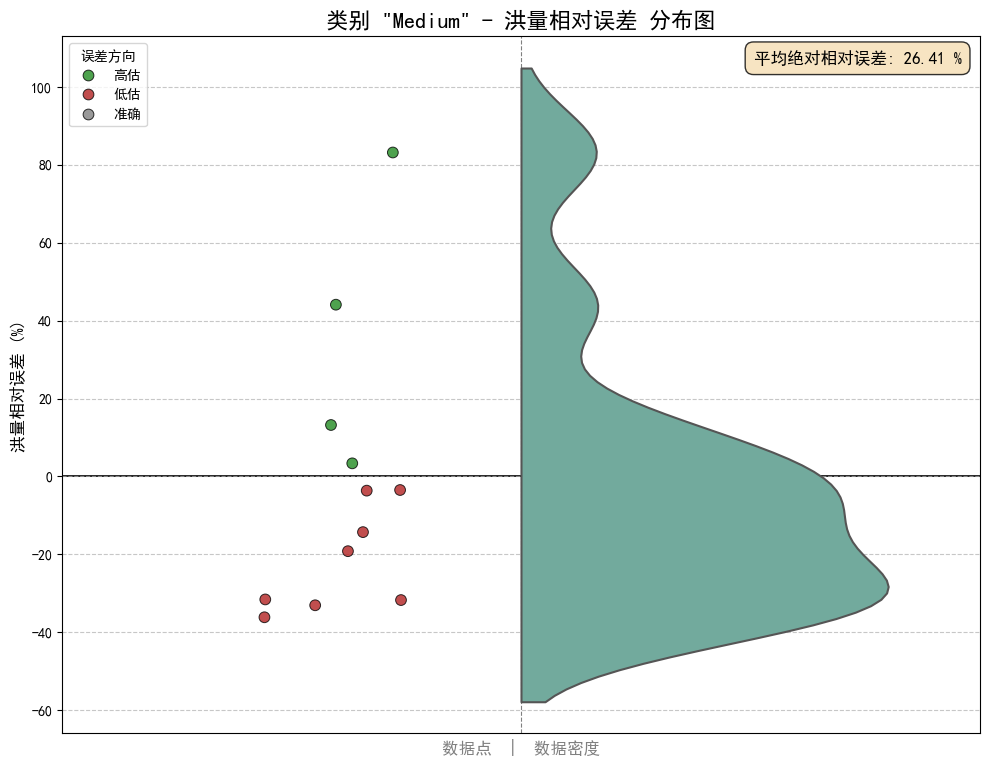

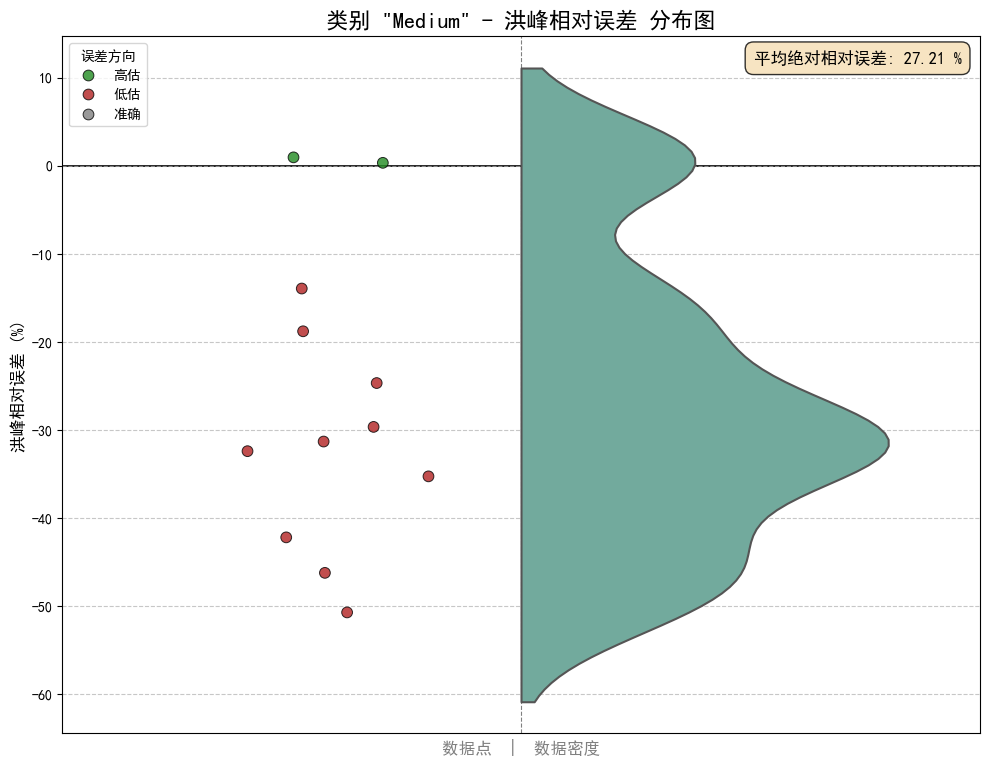


--- 正在为类别 'Small' 生成评估分布图 ---


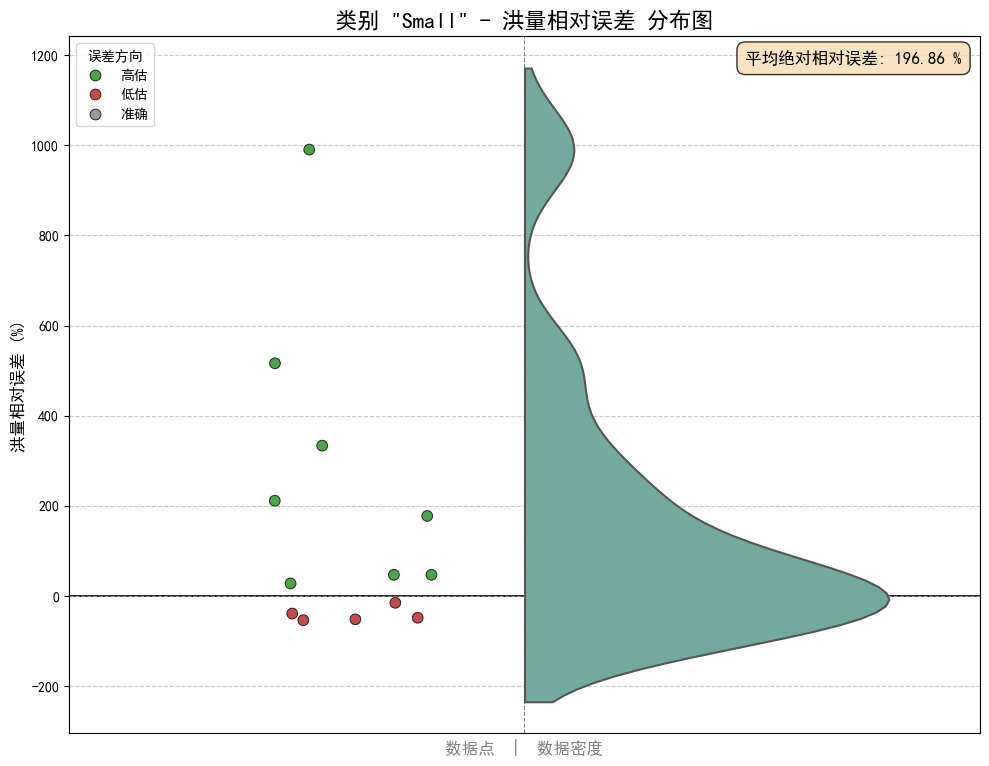

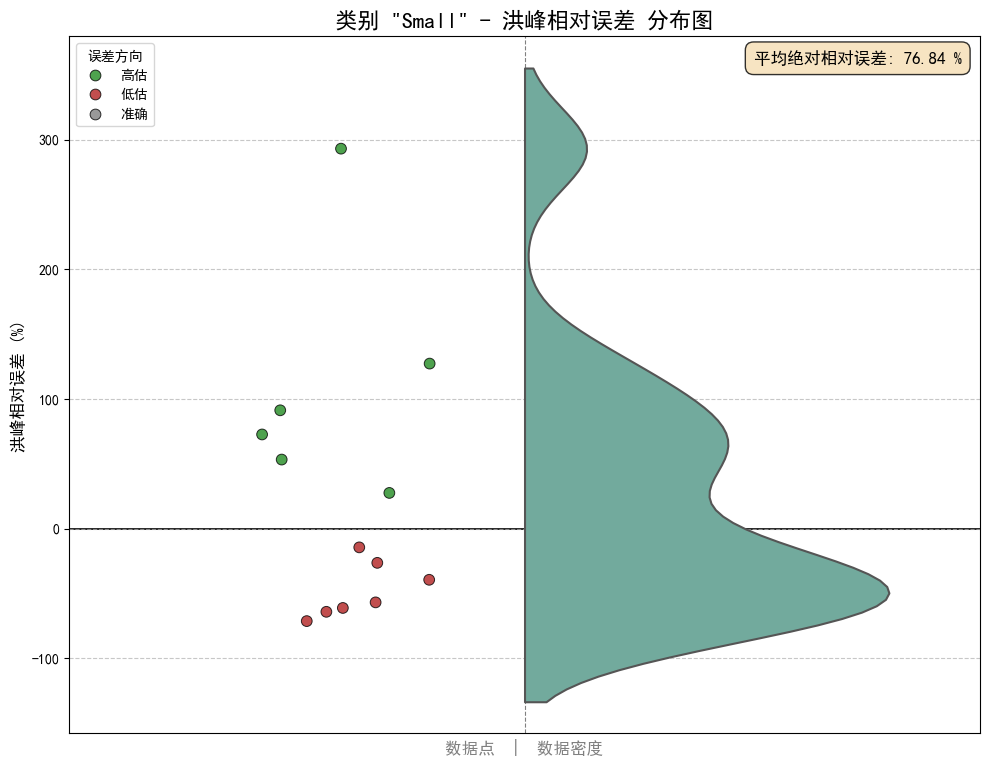

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'sans-serif'

# --- 绘图函数 ---
def plot_error_raincloud_for_category(data_rel, feature_name, category_name, palette):
    """
    为指定类别和特征绘制雨云图，并标注平均绝对相对误差。
    """
    if data_rel.empty:
        print(f"警告: 类别 '{category_name}' 的特征 '{feature_name}' 没有有效数据，无法绘图。")
        return

    # 准备用于绘图的DataFrame
    df_plot = pd.DataFrame({'rel_error': data_rel})
    df_plot['误差方向'] = np.sign(df_plot['rel_error']).map({1.0: '高估', -1.0: '低估', 0.0: '准确'})

    # 开始绘图
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # 1. 绘制小提琴图
    sns.violinplot(y='rel_error', data=df_plot, ax=ax, color="#69b3a2", 
                   inner=None, linewidth=1.5, bw_adjust=0.5, zorder=5)
    for collection in ax.collections:
        if isinstance(collection, plt.matplotlib.collections.PolyCollection):
            path = collection.get_paths()[0]
            vertices = path.vertices
            vertices[:, 0] = np.clip(vertices[:, 0], 0, np.inf)

    # 2. 绘制散点图
    x_scatter = -0.2 + (np.random.rand(len(df_plot)) * 0.2 - 0.1)
    sns.scatterplot(x=x_scatter, y='rel_error', data=df_plot, ax=ax, 
                    hue='误差方向', hue_order=['高估', '低估', '准确'], palette=palette, 
                    s=60, alpha=0.8, edgecolor='black', linewidth=0.7, zorder=10)
                  
    # 3. 计算并准备平均绝对相对误差文本
    mean_abs_rel_error = df_plot['rel_error'].abs().mean()
    stats_text = f"平均绝对相对误差: {mean_abs_rel_error:.2f} %"
    
    # 4. 在图中标注文本
    props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.8)
    ax.text(0.98, 0.98, stats_text, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', horizontalalignment='right', bbox=props)
    
    # 5. 美化图表
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.2, zorder=0)
    ax.set_ylabel(f"{feature_name} (%)", fontsize=12)
    ax.set_xlabel("数据点  |  数据密度", fontsize=12, color='gray')
    ax.set_title(f'类别 "{category_name.capitalize()}" - {feature_name} 分布图', fontsize=16)
    ax.set_xticks([])
    ax.set_xlim(-0.5, 0.5)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, title='误差方向', loc='upper left')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# --- 主程序 ---
if __name__ == "__main__":
    # 1. 定义要读取的文件路径
    csv_filepath = "categorized_uh_evaluation_report.csv"
    
    # 2. 读取CSV文件
    try:
        df_report = pd.read_csv(csv_filepath)
        print(f"成功读取文件: {csv_filepath}")
        print("文件内容预览:")
        print(df_report.head())
    except FileNotFoundError:
        print(f"错误: 文件 '{csv_filepath}' 未找到。请确保文件与脚本在同一目录下，或提供完整路径。")
        exit()
    except Exception as e:
        print(f"读取文件时发生错误: {e}")
        exit()

    # 3. 检查必要的列是否存在
    required_cols = ['所属类别', '洪量相对误差(%)', '洪峰相对误差(%)']
    if not all(col in df_report.columns for col in required_cols):
        print(f"错误: CSV文件中缺少必要的列。需要: {required_cols}")
        exit()

    # 4. 定义绘图任务
    error_features_to_plot = {
        "洪量相对误差(%)": "洪量相对误差",
        "洪峰相对误差(%)": "洪峰相对误差"
    }
    
    # 定义颜色: 绿色代表正值(高估), 红色代表负值(低估)
    error_palette = {'高估': 'forestgreen', '低估': 'firebrick', '准确': 'gray'}

    # 5. 循环遍历每个类别和每个误差指标进行绘图
    categories = df_report['所属类别'].unique()

    for category in categories:
        if pd.isna(category): continue # 跳过未分类的事件

        # 筛选出当前类别的数据
        df_category = df_report[df_report['所属类别'] == category]
        
        print(f"\n--- 正在为类别 '{category.capitalize()}' 生成评估分布图 ---")
        
        for col_name, title_name in error_features_to_plot.items():
            # 提取数据并移除空值
            plot_data = df_category[col_name].dropna()
            
            if not plot_data.empty:
                plot_error_raincloud_for_category(
                    data_rel=plot_data,
                    feature_name=title_name,
                    category_name=category,
                    palette=error_palette
                )
            else:
                print(f"  警告: 类别 '{category}' 的特征 '{title_name}' 没有有效数据。")

按 '类别 == "Large"' 筛选后，共找到 22 个事件。
正在为 '洪量相对误差(%)' 生成图表...


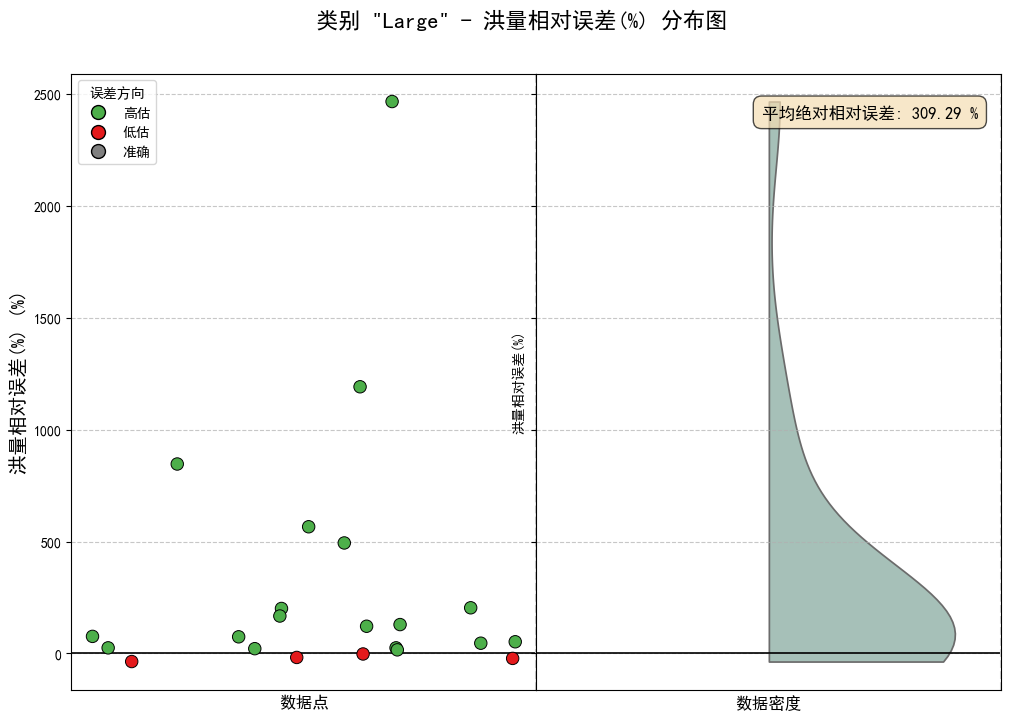

正在为 '洪峰相对误差(%)' 生成图表...


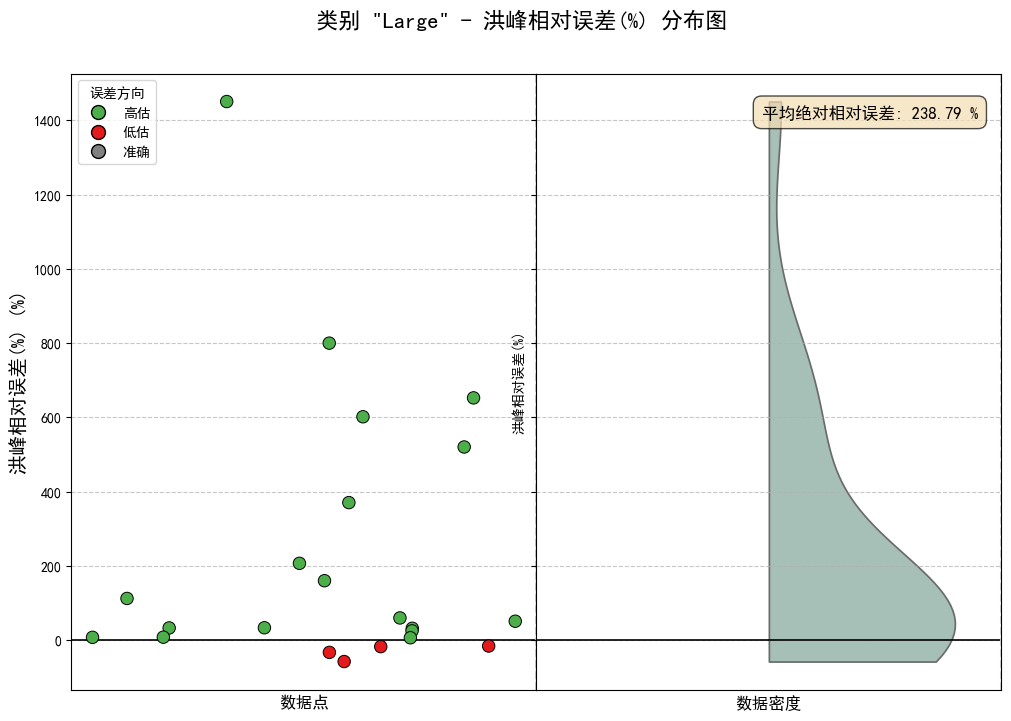

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D
import seaborn as sns
import io

# --- 步骤 1: 设置环境和创建模拟数据 ---

# 设置matplotlib以正确显示中文和负号
plt.rcParams['font.sans-serif'] = ['SimHei']  # 'SimHei' 是常用的黑体中文字体
plt.rcParams['axes.unicode_minus'] = False

# 创建一个模拟的CSV文件，内容与您图片中的一致
# 【重要更新】: 增加了 '类别' 列来模拟您的真实数据结构。
#               假设前22个事件为 "Large"，后2个为 "Small"，以匹配您说的“22个事件”。
csv_data = """文件名,NSE,洪量相对误差(%),洪峰相对误差(%),类别
20000710.csv,-795.8958,2467.0884,1450.7158,Large
20030822.csv,-113.4764,566.3365,652.4562,Large
20140721.csv,-95.6508,1192.0612,520.1887,Large
20090713.csv,-91.0069,846.8554,799.9009,Large
20020722.csv,-48.8314,493.9438,370.3435,Large
19890717.csv,-47.8901,204.1479,601.5638,Large
20160631.csv,-6.3311,201.1035,206.8114,Large
19900706.csv,-4.8143,76.3203,159.9486,Large
20150802.csv,-2.3466,167.3991,112.1978,Large
19990730.csv,-1.5109,121.6530,50.8453,Large
20100819.csv,-1.1607,25.0506,33.2099,Large
20060730.csv,-0.6580,74.3761,7.4615,Large
19930724.csv,-0.3897,21.3858,31.8513,Large
20170802.csv,-0.3873,129.1157,24.8326,Large
20130701.csv,-0.3106,45.8561,32.7639,Large
19880816.csv,-0.1756,25.0454,59.7075,Large
20080731.csv,0.3624,-2.2934,7.8771,Large
20070811.csv,0.5494,16.1440,-17.5825,Large
19860731.csv,0.5805,-17.7865,-33.0668,Large
19920901.csv,0.5823,52.2856,-15.9708,Large
19850818.csv,0.5836,-36.1067,-57.7441,Large
20050808.csv,0.6164,-22.0957,6.3021,Large
19950817.csv,0.6281,-18.3759,5.6687,Small
19960729.csv,0.6916,-37.2559,-48.7447,Small
"""

# 将字符串数据写入一个虚拟文件
with open('shared_uh_evaluation_report.csv', 'w', encoding='utf-8') as f:
    f.write(csv_data)

# --- 步骤 2: 定义绘图函数 ---

def create_raincloud_plot(data_series, column_name, category_name="Large"):
    """
    根据给定的数据系列(Pandas Series)和列名，生成一张雨云图。
    
    参数:
    data_series (pd.Series): 需要绘制的数据。
    column_name (str): 数据列的名称，用于图表标题和标签。
    category_name (str): 筛选的类别名称，用于图表标题。
    """
    # 计算平均绝对误差
    avg_abs_error = data_series.abs().mean()
    
    # --- 设置画布和子图布局 ---
    fig = plt.figure(figsize=(12, 8))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], wspace=0)
    ax_scatter = fig.add_subplot(gs[0])
    ax_density = fig.add_subplot(gs[1], sharey=ax_scatter)

    # --- 左侧子图：数据点 (散点图) ---
    colors = ['#4daf4a' if val >= 0 else '#e41a1c' for val in data_series]
    jitter = np.random.uniform(-0.1, 0.1, size=len(data_series))
    
    ax_scatter.scatter(
        jitter, 
        data_series, 
        color=colors, 
        edgecolor='black', 
        linewidth=0.7, 
        s=80,
        zorder=3
    )
    
    # 【样式更新】: 根据您的示例图，添加一个"准确"的图例项
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', label='高估', markerfacecolor='#4daf4a', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='低估', markerfacecolor='#e41a1c', markersize=10, markeredgecolor='black'),
        Line2D([0], [0], marker='o', color='w', label='准确', markerfacecolor='grey', markersize=10, markeredgecolor='black')
    ]
    ax_scatter.legend(handles=legend_elements, title="误差方向", loc='upper left')

    # --- 右侧子图：数据密度 (半小提琴图) ---
    sns.violinplot(
        ax=ax_density, 
        y=data_series, 
        color="#a2c4b9", 
        inner=None,
        cut=0
    )
    
    for collection in ax_density.collections:
        path = collection.get_paths()[0]
        vertices = path.vertices
        vertices[:, 0] = np.maximum(vertices[:, 0], 0)
    
    # --- 统一的样式设置 ---
    for ax in [ax_scatter, ax_density]:
        ax.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)
        ax.axhline(0, color='black', linestyle='-', linewidth=1.2, zorder=2)
        ax.axvline(x=ax.get_xlim()[1], color='lightgrey', linestyle='--') # 添加垂直分割线

    ax_scatter.set_ylabel(f"{column_name} (%)", fontsize=14)
    ax_scatter.set_xlabel("数据点", fontsize=12)
    
    plt.setp(ax_density.get_yticklabels(), visible=False)
    ax_density.set_xlabel("数据密度", fontsize=12)
    
    ax_scatter.set_xticks([])
    ax_density.set_xticks([])
    
    text_str = f'平均绝对相对误差: {avg_abs_error:.2f} %'
    props = dict(boxstyle='round,pad=0.5', facecolor='wheat', alpha=0.7)
    ax_density.text(
        0.95, 0.95, text_str, 
        transform=ax_density.transAxes, 
        fontsize=12,
        fontweight='bold',
        verticalalignment='top', 
        horizontalalignment='right', 
        bbox=props
    )
    
    # 【重要更新】: 修改图表标题以匹配您的示例
    fig.suptitle(f'类别 "{category_name}" - {column_name} 分布图', fontsize=16, y=0.96)
    
    plt.show()


# --- 步骤 3: 主程序 ---

# 读取CSV文件
file_path = 'shared_uh_evaluation_report.csv'
try:
    df = pd.read_csv(file_path)

    # 【重要更新】: 更改筛选逻辑
    # 不再使用 df['NSE'] > 0，而是根据 '类别' 列进行筛选
    filter_category = 'Large'
    df_filtered = df[df['类别'] == filter_category].copy()
    
    # 打印筛选出的事件数量，进行验证
    print(f"按 '类别 == \"{filter_category}\"' 筛选后，共找到 {len(df_filtered)} 个事件。")

    if df_filtered.empty:
        print(f"筛选条件 '类别 == \"{filter_category}\"' 没有匹配到任何数据。")
    else:
        volume_error_col = '洪量相对误差(%)'
        peak_error_col = '洪峰相对误差(%)'

        # 为 "洪量相对误差(%)" 画图
        print(f"正在为 '{volume_error_col}' 生成图表...")
        create_raincloud_plot(df_filtered[volume_error_col], volume_error_col, category_name=filter_category)

        # 为 "洪峰相对误差(%)" 画图
        print(f"正在为 '{peak_error_col}' 生成图表...")
        create_raincloud_plot(df_filtered[peak_error_col], peak_error_col, category_name=filter_category)

except FileNotFoundError:
    print(f"错误：找不到文件 '{file_path}'。请确保文件存在于正确的路径。")
except KeyError as e:
    print(f"错误: CSV文件中找不到列 {e}。请检查您的CSV文件列名是否正确，特别是'类别'列。")
except Exception as e:
    print(f"处理文件时发生错误: {e}")

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from matplotlib.font_manager import FontProperties
import os

# --- 全局配置 ---
try:
    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
except Exception:
    print("警告: 中文字体'SimHei'未找到，图表中的中文可能无法正确显示。")

# --- 全局常量 ---
R_UH = 10.0
DELTA_T_HOURS = 3.0
delta_t_seconds = DELTA_T_HOURS * 3600.0

# --- 辅助函数：数据预处理 (与之前相同) ---
def preprocess_single_event_data(csv_filepath):
    """读取并处理单个洪水事件。"""
    try:
        encodings_to_try = ['utf-8', 'gbk', 'latin1']
        df = None
        for enc in encodings_to_try:
            try:
                df = pd.read_csv(csv_filepath, encoding=enc)
                break
            except UnicodeDecodeError: continue
        if df is None: return None
    except Exception: return None

    time_col = '时间'; net_rain_col = '泰森多边形面雨量'; direct_runoff_col = '分割流量'
    if not all(col in df.columns for col in [time_col, net_rain_col, direct_runoff_col]): return None

    net_rain = pd.to_numeric(df[net_rain_col], errors='coerce').fillna(0).values
    direct_runoff = pd.to_numeric(df[direct_runoff_col], errors='coerce').fillna(0).values
    
    first_rain_idx, has_effective_rain = 0, False
    for i, r_val in enumerate(net_rain):
        if r_val > 1e-6:
            first_rain_idx = i
            has_effective_rain = True
            break
    if not has_effective_rain: return None

    last_rain_idx = len(net_rain) - 1
    for i in range(len(net_rain) - 1, first_rain_idx - 1, -1):
        if net_rain[i] > 1e-6:
            last_rain_idx = i
            break
            
    if np.sum(net_rain) < 1e-6: return None
    
    P_eff_event = net_rain[first_rain_idx : last_rain_idx + 1]
    m_eff_event = len(P_eff_event)
    if m_eff_event == 0: return None

    Q_obs_eff_event = direct_runoff[first_rain_idx:]
    l_obs_eff_event = len(Q_obs_eff_event)
    n_event_specific = l_obs_eff_event - m_eff_event + 1
    if n_event_specific <= 0: return None
        
    return {
        "P_eff": P_eff_event, 
        "Q_obs_eff": Q_obs_eff_event, 
        "m_eff": m_eff_event, 
        "n_specific": n_event_specific, 
        "filepath": csv_filepath
    }

# --- 核心计算函数 (与之前相同) ---
def convolve_uh(P, U, R_UH_val):
    m_p, n_u = len(P), len(U); len_q = m_p + n_u - 1
    if len_q < 0: len_q = 0 
    Q_sim = np.zeros(len_q)
    P_normalized = P / R_UH_val
    for i in range(m_p):
        if P_normalized[i] > 1e-9:
            for k in range(n_u):
                if (i + k) < len_q: Q_sim[i + k] += P_normalized[i] * U[k]
    return Q_sim

def objective_function_multi_event(U_params, list_of_event_data_for_opt, R_UH_val, 
                                   lambda_smooth, lambda_peak_violation, apply_peak_penalty_flag,
                                   common_n_uh):
    total_fit_loss = 0
    if len(U_params) != common_n_uh: return 1e18 
    for event_data in list_of_event_data_for_opt:
        P_event, Q_event_obs_for_opt = event_data["P_eff"], event_data["Q_obs_for_opt"]
        Q_sim_full_event = convolve_uh(P_event, U_params, R_UH_val)
        Q_sim_compare_event = Q_sim_full_event[:len(Q_event_obs_for_opt)]
        total_fit_loss += np.sum((Q_sim_compare_event - Q_event_obs_for_opt)**2)
    loss_smooth_val = np.sum(np.diff(U_params)**2) if len(U_params) > 1 else 0
    peak_violation_penalty_val = 0
    if apply_peak_penalty_flag and len(U_params) > 2:
        actual_k_peak = np.argmax(U_params)
        for j in range(actual_k_peak):
            if U_params[j+1] < U_params[j] - 1e-6: peak_violation_penalty_val += (U_params[j] - U_params[j+1])**2
        for j in range(actual_k_peak, len(U_params) - 1):
            if U_params[j+1] > U_params[j] + 1e-6: peak_violation_penalty_val += (U_params[j+1] - U_params[j])**2
    return total_fit_loss + lambda_smooth * loss_smooth_val + lambda_peak_violation * peak_violation_penalty_val

# --- 主程序 ---
if __name__ == "__main__":
    # 1. 数据预处理
    data_folder = "data_source/" 
    try:
        csv_files = [os.path.join(data_folder, f) for f in os.listdir(data_folder) if f.endswith('.csv')]
        if not csv_files: exit()
    except FileNotFoundError: exit()

    all_events_processed_data = [d for d in [preprocess_single_event_data(f) for f in csv_files] if d]
    if not all_events_processed_data: exit()
    print(f"成功预处理 {len(all_events_processed_data)} 场洪水事件。")

    # 2. 确定共享单位线长度
    n_specific_values = [data["n_specific"] for data in all_events_processed_data if data["n_specific"] > 0]
    if not n_specific_values: exit()
    common_n_uh = int(np.max(n_specific_values))
    if common_n_uh <= 1: common_n_uh = max(3, common_n_uh if common_n_uh > 0 else 3)
    print(f"确定的共享单位线长度 common_n_uh: {common_n_uh}")

    # 3. 准备优化数据集
    list_of_event_data_for_opt_final = []
    for event_data in all_events_processed_data:
        P_eff, Q_obs_eff, m_eff = event_data["P_eff"], event_data["Q_obs_eff"], event_data["m_eff"]
        target_q_len_event = m_eff + common_n_uh - 1
        if target_q_len_event < 0: target_q_len_event = 0
        Q_obs_for_opt_event = np.zeros(target_q_len_event)
        len_to_copy = min(len(Q_obs_eff), target_q_len_event)
        Q_obs_for_opt_event[:len_to_copy] = Q_obs_eff[:len_to_copy]
        list_of_event_data_for_opt_final.append({"P_eff": P_eff, "Q_obs_for_opt": Q_obs_for_opt_event})

    # 4. 设置优化参数并执行
    U_initial_guess = np.zeros(common_n_uh)
    bounds = [(0, None) for _ in range(common_n_uh)] 
    smoothing_factor = 0.1
    peak_violation_weight = 10000.0 # 使用您指定的权重
    apply_peak_penalty_in_opt = common_n_uh > 2
    print(f"\n开始使用 {len(list_of_event_data_for_opt_final)} 场洪水数据优化共享单位线...")
    print(f"平滑因子: {smoothing_factor}, 单峰惩罚因子: {peak_violation_weight if apply_peak_penalty_in_opt else 'N/A'}")
    result_shared_uh = minimize(
        objective_function_multi_event, U_initial_guess,
        args=(list_of_event_data_for_opt_final, R_UH, smoothing_factor, peak_violation_weight, apply_peak_penalty_in_opt, common_n_uh),
        method='L-BFGS-B', bounds=bounds, options={'disp': True, 'maxiter': 500}
    )
    U_optimized_shared = result_shared_uh.x if (result_shared_uh.success or result_shared_uh.status in [0,2]) else None
    if U_optimized_shared is None:
        print("共享单位线优化失败，程序终止。")
        exit()
    print("\n共享单位线优化完成！")

    # 5. 详细评估共享单位线在所有事件上的表现，并准备输出
    final_report_data = []
    for event_data in all_events_processed_data:
        P_event, Q_obs_event_full = event_data["P_eff"], event_data["Q_obs_eff"]
        event_filename = os.path.basename(event_data["filepath"])
        Q_sim_event_full = convolve_uh(P_event, U_optimized_shared, R_UH)
        Q_sim_event_compare = Q_sim_event_full[:len(Q_obs_event_full)]
        
        # 初始化指标
        nse = np.nan
        volume_rel_error = np.nan
        peak_rel_error = np.nan
        
        if len(Q_obs_event_full) > 0 and len(Q_sim_event_compare) == len(Q_obs_event_full):
            # NSE
            mean_obs = np.mean(Q_obs_event_full)
            den_nse = np.sum((Q_obs_event_full - mean_obs)**2)
            if den_nse == 0: 
                nse = 1.0 if np.allclose(Q_sim_event_compare, Q_obs_event_full) else -np.inf
            else: 
                nse = 1 - (np.sum((Q_obs_event_full - Q_sim_event_compare)**2) / den_nse)

            # 洪量相对误差 (带正负)
            vol_obs = np.sum(Q_obs_event_full) * delta_t_seconds
            vol_sim = np.sum(Q_sim_event_compare) * delta_t_seconds
            if vol_obs > 1e-6: 
                volume_rel_error = ((vol_sim - vol_obs) / vol_obs) * 100.0
                
            # 洪峰相对误差 (带正负)
            peak_obs = np.max(Q_obs_event_full)
            peak_sim = np.max(Q_sim_event_compare)
            if peak_obs > 1e-6: 
                peak_rel_error = ((peak_sim - peak_obs) / peak_obs) * 100.0
                
        final_report_data.append({
            "文件名": event_filename, 
            "NSE": nse, 
            "洪量相误(%)": volume_rel_error, 
            "洪峰相误(%)": peak_rel_error
        })

    # 6. 将最终结果保存到CSV文件
    report_df = pd.DataFrame(final_report_data)
    report_df_sorted = report_df.sort_values(by="NSE", ascending=True).reset_index(drop=True)

    output_csv_path = "shared_uh_evaluation_report_with_signed_errors.csv"
    try:
        report_df_sorted.to_csv(output_csv_path, index=False, encoding='utf-8-sig', float_format='%.4f')
        print(f"\n✅ 完整的评估报告已成功保存到文件: {output_csv_path}")
    except Exception as e:
        print(f"\n❌ 保存最终报告到文件失败: {e}")

    # (可选) 在Notebook中打印预览
    print("\n--- 共享单位线评估报告预览 (按NSE排序) ---")
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.width', 100)
    print(report_df_sorted)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.width')

成功预处理 38 场洪水事件。
确定的共享单位线长度 common_n_uh: 55

开始使用 38 场洪水数据优化共享单位线...
平滑因子: 0.1, 单峰惩罚因子: 10000.0

共享单位线优化完成！

✅ 完整的评估报告已成功保存到文件: shared_uh_evaluation_report_with_signed_errors.csv

--- 共享单位线评估报告预览 (按NSE排序) ---
             文件名         NSE      洪量相误(%)      洪峰相误(%)
0   20000710.csv -795.908892  2467.097420  1450.728315
1   20030822.csv -113.478242   566.332915   652.440940
2   20140721.csv  -95.652103  1192.067809   520.168902
3   20090713.csv  -91.008349   846.855982   799.894374
4   20020722.csv  -48.832253   493.944443   370.356005
5   19890717.csv  -47.890841   204.148793   601.563609
6   20160631.csv   -6.331213   201.105159   206.802522
7   19900706.csv   -4.814492    76.321366   159.936791
8   20150802.csv   -2.346649   167.398753   112.195526
9   19990730.csv   -1.510986   121.653672    50.850119
10  20100819.csv   -1.160713    25.050822    33.206091
11  20060730.csv   -0.657979    74.376322     7.455946
12  19930724.csv   -0.389714    21.386294    31.849712
13  20170802.csv   -0.